### FFNN economic choice simplest

'/mnt/c/Users/imcir/Desktop/CIENCIA DATOS/Segundo cuatrimestre/TFM/Código/Modules' already in sys.path
Setup Complete.
Configuration loaded:
  A_to_B_ratio: 2.2
  reward_B: 1
  abort_penalty: -0.1
  actor_hidden_size: 100
  critic_hidden_size: 100
  actor_layers: 1
  critic_layers: 1
  layer_type: Dense
  actor_prob_connection: 0.1
  critic_prob_connection: 1.0
  actor_lr: 0.001
  critic_lr: 0.001
  num_episodes: 5000
  gamma: 1.0
  l2_actor: 0.0001
  l2_critic: 0.0001
  print_interval: 100
  record_history: 1
Creating Padoa-Schioppa environment...
Observation size: 2, Action size: 3
Environment reset. Initial info: {'nA': 1, 'nB': 6, 'rL': 2.2, 'rR': 6.0, 'A_to_B_ratio': 2.2, 'trial_juice_LR': ('A', 'B'), 'trial_offer_BA': (6, 1), 'reward': 0.0, 'action': None}
Initializing Actor-Critic Agent...
No weights loaded (load_weights_path is None). Starting from scratch.
Agent Initialized.
Starting training for 5000 episodes...
Episode 100	Total Reward: 2.20	State [0.1 0.2]	Actor Loss: 0.718

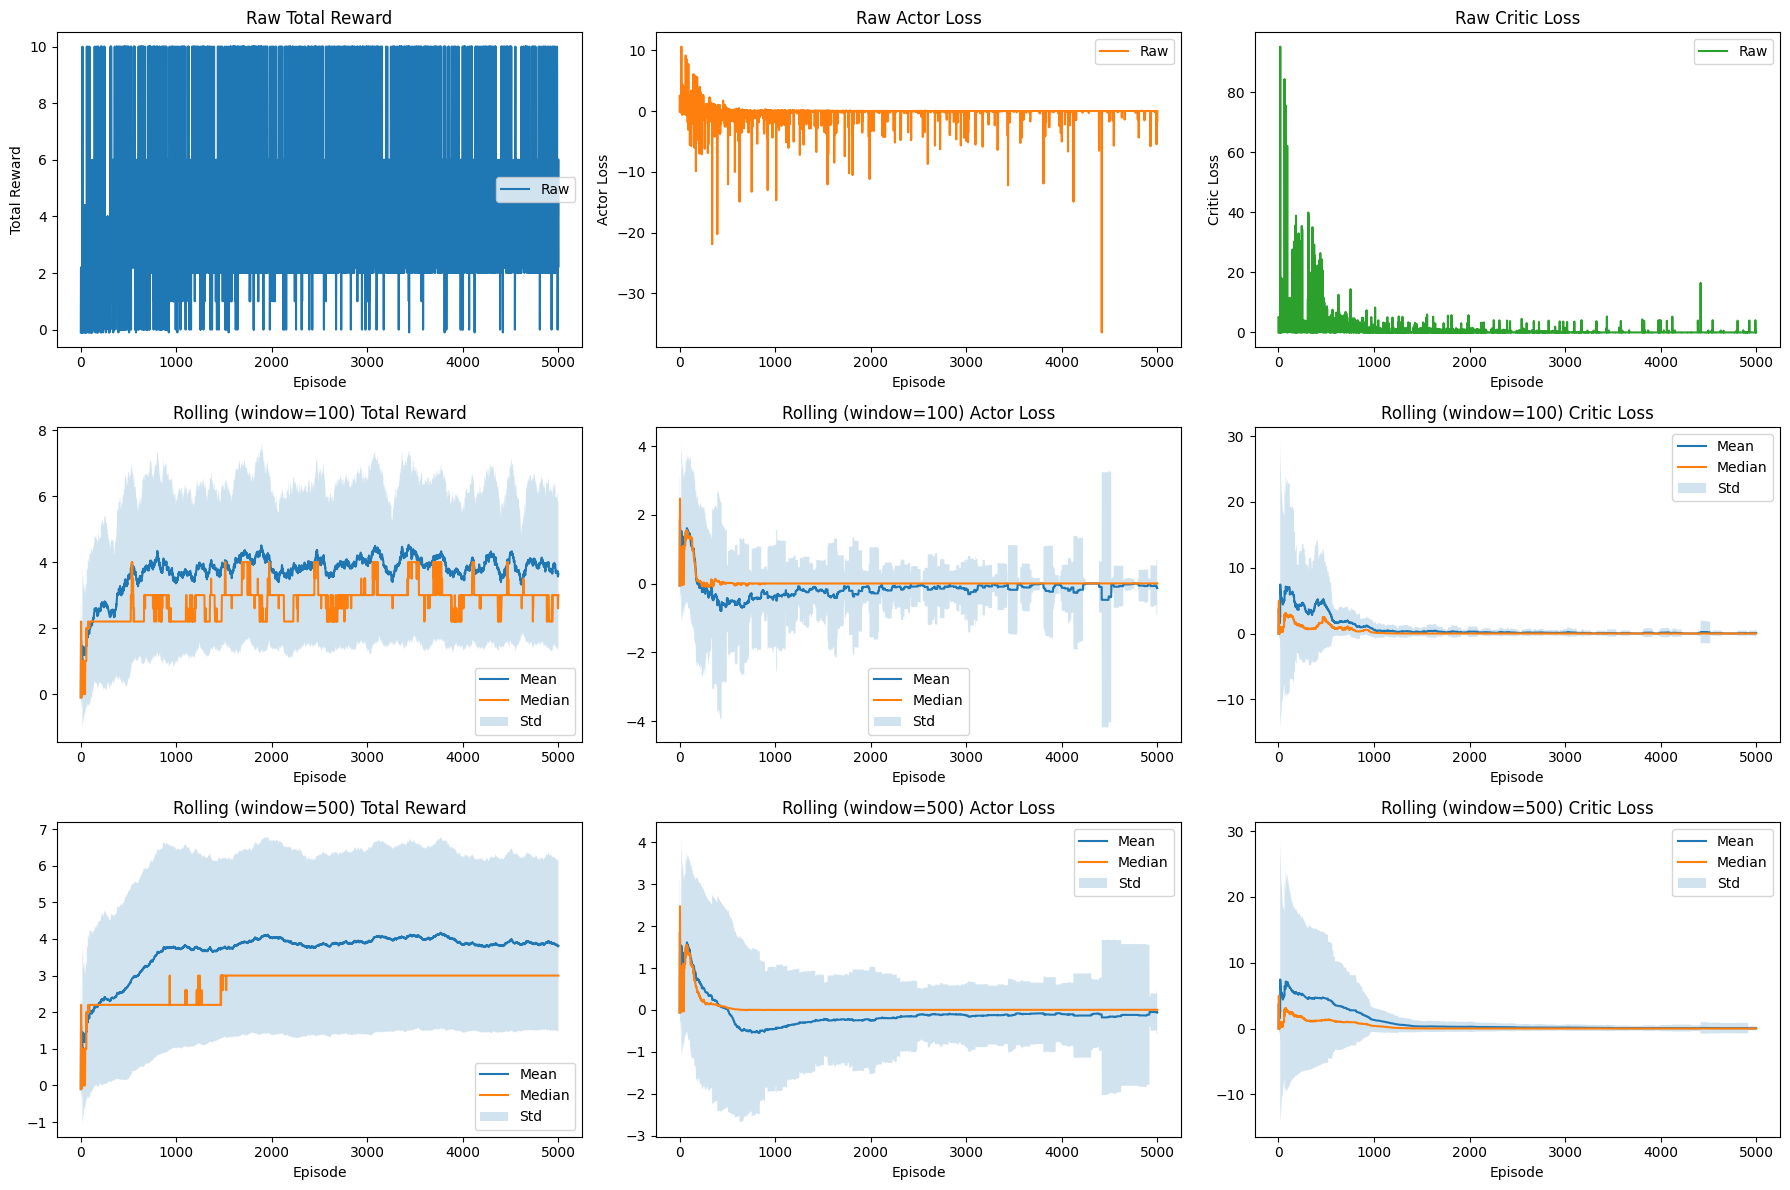

Metrics plot displayed.
Firing rate data not available (models might be Dense or logging was disabled/failed).

  Plotting Psychometric Curve for this stage...


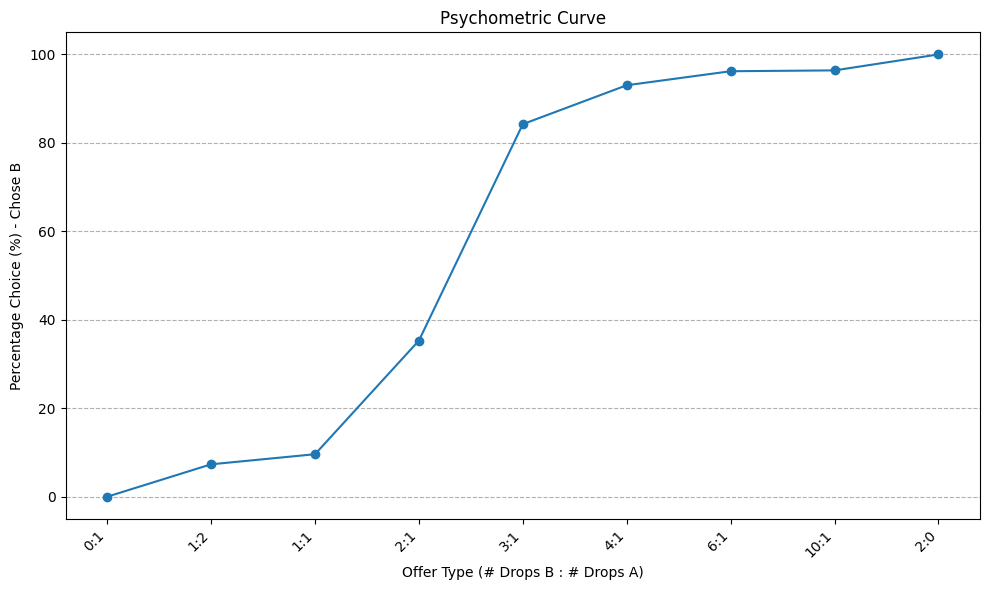

Closing the environment...
Environment closed.


In [3]:
# --- Imports ---
import os
import sys
import gymnasium as gym
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

# --- GPU Configuration ---
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

# --- Add Modules directory to Python path ---
module_path = os.path.abspath(os.path.join('.', 'Modules'))

if module_path not in sys.path:
    sys.path.append(module_path)
    print(f"Added '{module_path}' to sys.path")
else:
    print(f"'{module_path}' already in sys.path")

# --- Import custom modules ---
from env_economic_choice_simplest import EconomicChoiceEnv
from actor_critic import ActorCriticAgent
from reinforce import train_agent
from helper_functions import plot_metrics, plot_firing_rates, plot_psychometric_curve

# --- Set Random Seeds ---
seed_value = 0
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
random.seed(seed_value)

print("Setup Complete.")

# --- Define Paths for Loading/Saving ---
load_weights_path = None
save_weights_path = "saved_models_80/stage4"

# Ensure save directory exists
save_dir = os.path.dirname(save_weights_path)
if save_dir and not os.path.exists(save_dir):
    os.makedirs(save_dir)
    print(f"Created directory '{save_dir}'")


# --- Training Configuration ---
config = {
    # Environment specific params
    "A_to_B_ratio": 2.2,
    "reward_B": 1,
    "abort_penalty":-0.1,

    # Agent architecture
    "actor_hidden_size": 100,
    "critic_hidden_size": 100,
    "actor_layers": 1,
    "critic_layers": 1,
    "layer_type": "Dense",
    "actor_prob_connection": 0.1,
    "critic_prob_connection": 1.0,

    # Training hyperparameters
    "actor_lr": 1e-3,
    "critic_lr": 1e-3,
    "num_episodes": 5000,
    "gamma": 1.0,
    "l2_actor": 1e-4,
    "l2_critic": 1e-4,

    # Training process  
    "print_interval": 100,
    "record_history": 1
}

print("Configuration loaded:")
for key, value in config.items():
    print(f"  {key}: {value}")

# --- Environment Setup ---
print("Creating Padoa-Schioppa environment...")
env = EconomicChoiceEnv(
    A_to_B_ratio=config["A_to_B_ratio"],
    reward_B=config["reward_B"],
    abort_penalty=config["abort_penalty"]
)

# Get observation and action space sizes from the actual environment instance
obs_size = env.observation_space.shape[0]
act_size = env.action_space.n
print(f"Observation size: {obs_size}, Action size: {act_size}")

initial_obs, initial_info = env.reset(seed=seed_value)
print(f"Environment reset. Initial info: {initial_info}")

# --- Agent Setup ---
print("Initializing Actor-Critic Agent...")
agent = ActorCriticAgent(
    obs_size=obs_size,
    act_size=act_size,
    actor_hidden_size=config["actor_hidden_size"],
    critic_hidden_size=config["critic_hidden_size"],
    actor_layers=config["actor_layers"],
    critic_layers=config["critic_layers"],
    actor_lr=config["actor_lr"],
    critic_lr=config["critic_lr"],
    actor_prob_connection=config["actor_prob_connection"],
    critic_prob_connection=config["critic_prob_connection"],
    layer_type=config["layer_type"]
)

# Load weights
if load_weights_path:
    print(f"Attempting to load weights from: {load_weights_path}")
    load_successful = agent.load_weights(load_weights_path)
    if not load_successful:
        print(f"WARNING: Failed to load weights. Starting training with initialized weights.")
else:
    print("No weights loaded (load_weights_path is None). Starting from scratch.")

print("Agent Initialized.")

# --- Training ---
print(f"Starting training for {config['num_episodes']} episodes...")

total_rewards_history, actor_loss_history, critic_loss_history, \
actor_firing_rates, critic_firing_rates,  measurements_juices = train_agent(
    env=env,
    agent=agent,
    num_episodes=config["num_episodes"],
    gamma=config["gamma"],
    print_interval=config["print_interval"],
    l2_actor=config["l2_actor"],
    l2_critic=config["l2_critic"],
    record_history=config["record_history"]
)

print("\nTraining finished.")

# Save weights
if save_weights_path:
    print(f"Saving agent weights to: {save_weights_path}")
    agent.save_weights(save_weights_path)
else:
    print("No save path specified (save_weights_path is None). Weights not saved.")

# --- Plot Training Metrics ---
print("Plotting training metrics...")
# Adjust window sizes if needed based on num_episodes
plot_metrics(
    total_rewards_history,
    actor_loss_history,
    critic_loss_history,
    window_1=max(20, config["num_episodes"] // 50),
    window_2=max(50, config["num_episodes"] // 10)
)

print("Metrics plot displayed.")

# --- Plot Firing Rates ---
if actor_firing_rates is not None and critic_firing_rates is not None:
    print("Plotting neuron firing rates...")
    plot_firing_rates(actor_firing_rates, critic_firing_rates)
    print("Firing rate plot displayed.")
# Add checks for partial data as before...
elif actor_firing_rates is not None:
     print("Plotting only Actor firing rates (Critic might be Dense or logging failed)...")
     pass # Add specific plotting if desired
elif critic_firing_rates is not None:
     print("Plotting only Critic firing rates (Actor might be Dense or logging failed)...")
     pass # Add specific plotting if desired
else:
    print("Firing rate data not available (models might be Dense or logging was disabled/failed).")

# --- Plot psychometric curves ---
print("\n  Plotting Psychometric Curve for this stage...")
plot_psychometric_curve(measurements_juices, title=f"Psychometric Curve")

# --- Close the Environment ---
print("Closing the environment...")
env.close()
print("Environment closed.")

'/mnt/c/Users/imcir/Desktop/CIENCIA DATOS/Segundo cuatrimestre/TFM/Código/Modules' already in sys.path
Setup Complete.
Configuration loaded:
  A_to_B_ratio: 2.2
  reward_B: 1
  abort_penalty: -0.1
  actor_hidden_size: 100
  critic_hidden_size: 100
  actor_layers: 1
  critic_layers: 1
  layer_type: Dense
  actor_prob_connection: 0.1
  critic_prob_connection: 1.0
  actor_lr: 0.001
  critic_lr: 0.001
  num_episodes: 2000
  gamma: 1.0
  l2_actor: 0.0001
  l2_critic: 0.0001
  print_interval: 100
  record_history: 1
Creating Padoa-Schioppa environment...
Observation size: 2, Action size: 3
Environment reset. Initial info: {'nA': 1, 'nB': 6, 'rL': 2.2, 'rR': 6.0, 'A_to_B_ratio': 2.2, 'trial_juice_LR': ('A', 'B'), 'trial_offer_BA': (6, 1), 'reward': 0.0, 'action': None}
Initializing Actor-Critic Agent...
No weights loaded (load_weights_path is None). Starting from scratch.
Agent Initialized.
Starting training for 2000 episodes...
Episode 100	Total Reward: 2.20	State [0.1 0.2]	Actor Loss: 0.718

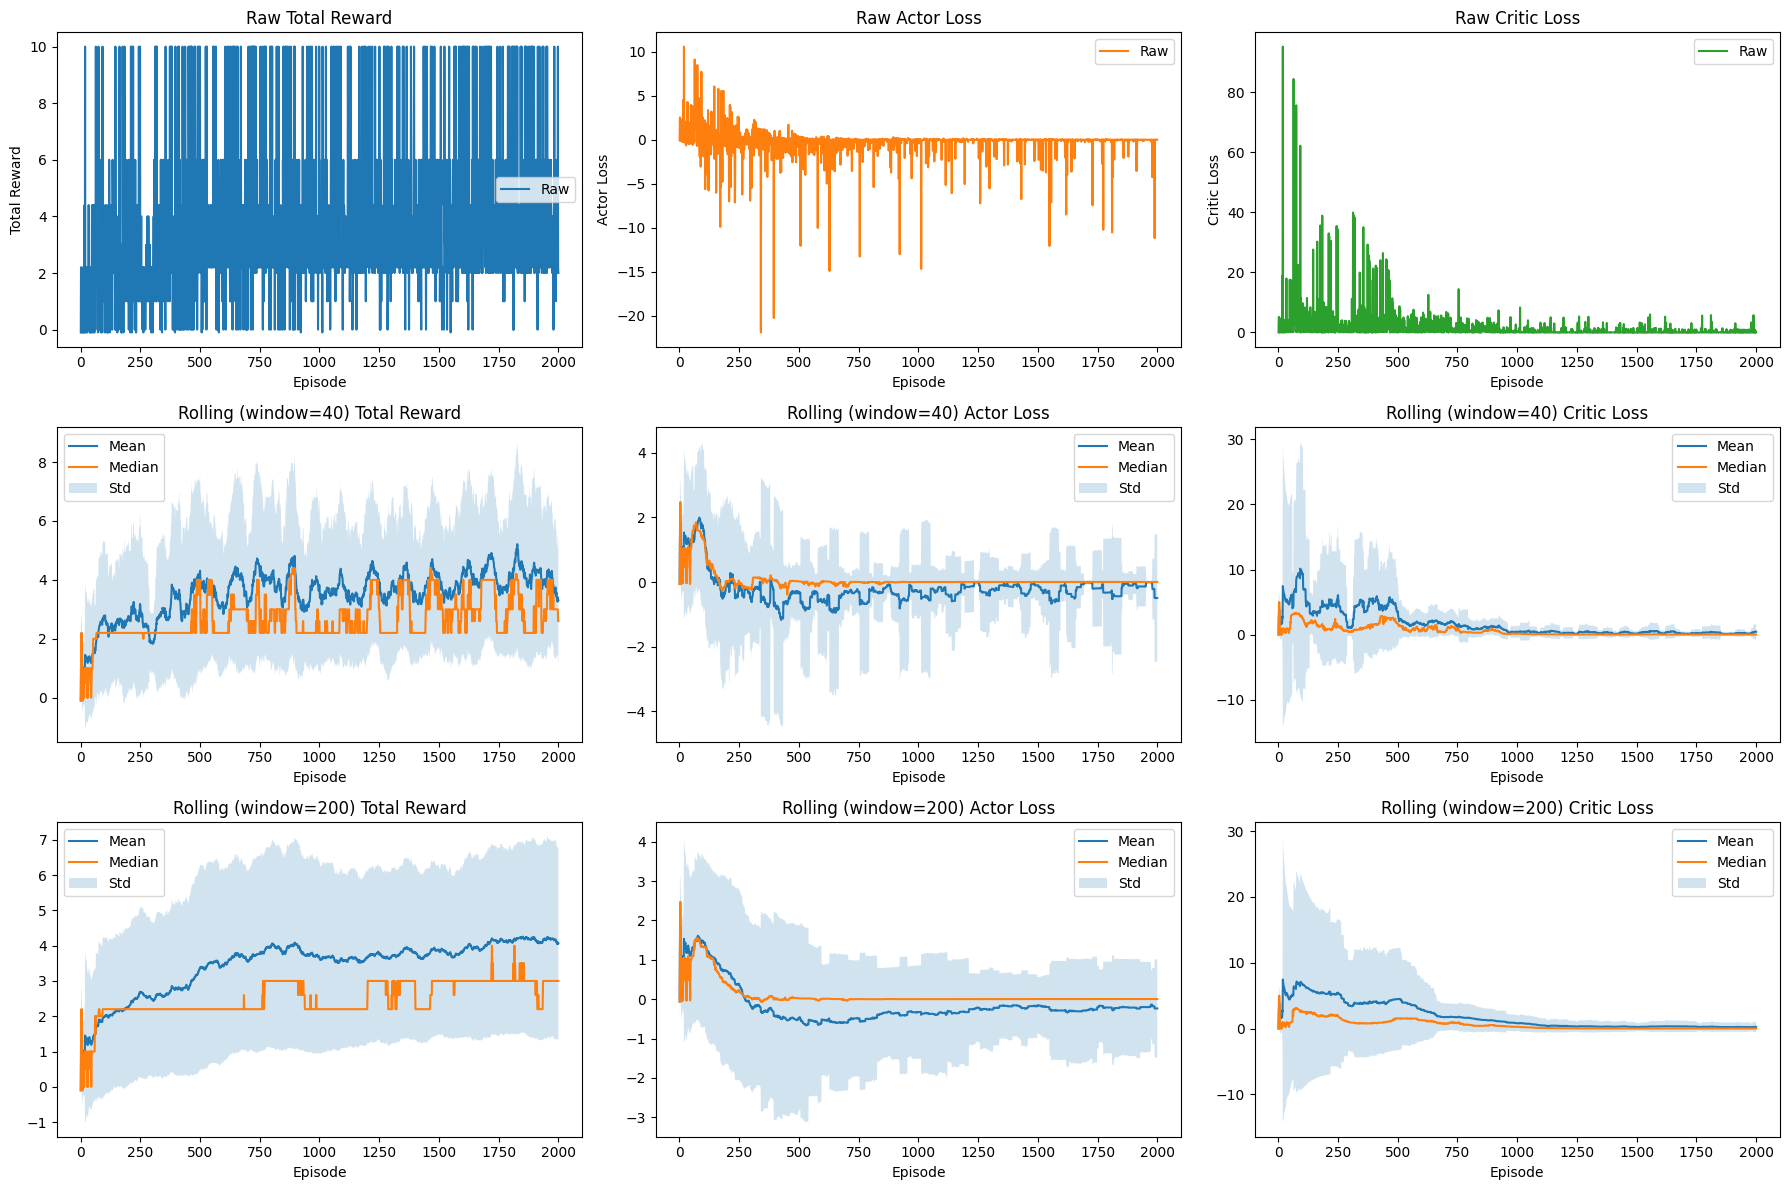

Metrics plot displayed.
Firing rate data not available (models might be Dense or logging was disabled/failed).

  Plotting Psychometric Curve for this stage...


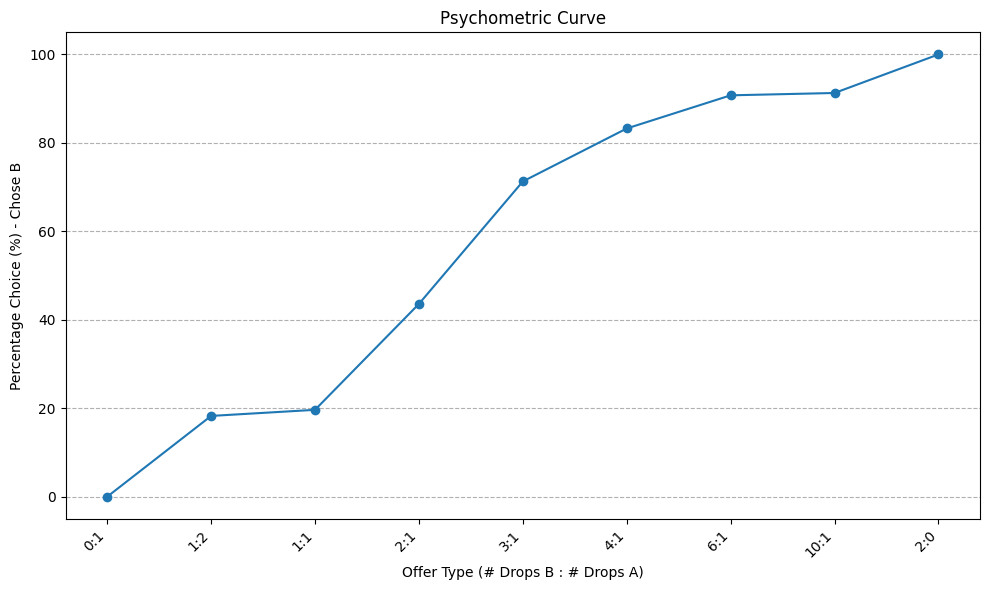

Closing the environment...
Environment closed.


In [4]:
# --- Imports ---
import os
import sys
import gymnasium as gym
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

# --- GPU Configuration ---
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

# --- Add Modules directory to Python path ---
module_path = os.path.abspath(os.path.join('.', 'Modules'))

if module_path not in sys.path:
    sys.path.append(module_path)
    print(f"Added '{module_path}' to sys.path")
else:
    print(f"'{module_path}' already in sys.path")

# --- Import custom modules ---
from env_economic_choice_simplest import EconomicChoiceEnv
from actor_critic import ActorCriticAgent
from reinforce import train_agent
from helper_functions import plot_metrics, plot_firing_rates, plot_psychometric_curve

# --- Set Random Seeds ---
seed_value = 0
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
random.seed(seed_value)

print("Setup Complete.")

# --- Define Paths for Loading/Saving ---
load_weights_path = None
save_weights_path = "saved_models_80/stage4"

# Ensure save directory exists
save_dir = os.path.dirname(save_weights_path)
if save_dir and not os.path.exists(save_dir):
    os.makedirs(save_dir)
    print(f"Created directory '{save_dir}'")


# --- Training Configuration ---
config = {
    # Environment specific params
    "A_to_B_ratio": 2.2,
    "reward_B": 1,
    "abort_penalty":-0.1,

    # Agent architecture
    "actor_hidden_size": 100,
    "critic_hidden_size": 100,
    "actor_layers": 1,
    "critic_layers": 1,
    "layer_type": "Dense",
    "actor_prob_connection": 0.1,
    "critic_prob_connection": 1.0,

    # Training hyperparameters
    "actor_lr": 1e-3,
    "critic_lr": 1e-3,
    "num_episodes": 2000,
    "gamma": 1.0,
    "l2_actor": 1e-4,
    "l2_critic": 1e-4,

    # Training process  
    "print_interval": 100,
    "record_history": 1
}

print("Configuration loaded:")
for key, value in config.items():
    print(f"  {key}: {value}")

# --- Environment Setup ---
print("Creating Padoa-Schioppa environment...")
env = EconomicChoiceEnv(
    A_to_B_ratio=config["A_to_B_ratio"],
    reward_B=config["reward_B"],
    abort_penalty=config["abort_penalty"]
)

# Get observation and action space sizes from the actual environment instance
obs_size = env.observation_space.shape[0]
act_size = env.action_space.n
print(f"Observation size: {obs_size}, Action size: {act_size}")

initial_obs, initial_info = env.reset(seed=seed_value)
print(f"Environment reset. Initial info: {initial_info}")

# --- Agent Setup ---
print("Initializing Actor-Critic Agent...")
agent = ActorCriticAgent(
    obs_size=obs_size,
    act_size=act_size,
    actor_hidden_size=config["actor_hidden_size"],
    critic_hidden_size=config["critic_hidden_size"],
    actor_layers=config["actor_layers"],
    critic_layers=config["critic_layers"],
    actor_lr=config["actor_lr"],
    critic_lr=config["critic_lr"],
    actor_prob_connection=config["actor_prob_connection"],
    critic_prob_connection=config["critic_prob_connection"],
    layer_type=config["layer_type"]
)

# Load weights
if load_weights_path:
    print(f"Attempting to load weights from: {load_weights_path}")
    load_successful = agent.load_weights(load_weights_path)
    if not load_successful:
        print(f"WARNING: Failed to load weights. Starting training with initialized weights.")
else:
    print("No weights loaded (load_weights_path is None). Starting from scratch.")

print("Agent Initialized.")

# --- Training ---
print(f"Starting training for {config['num_episodes']} episodes...")

total_rewards_history, actor_loss_history, critic_loss_history, \
actor_firing_rates, critic_firing_rates,  measurements_juices = train_agent(
    env=env,
    agent=agent,
    num_episodes=config["num_episodes"],
    gamma=config["gamma"],
    print_interval=config["print_interval"],
    l2_actor=config["l2_actor"],
    l2_critic=config["l2_critic"],
    record_history=config["record_history"]
)

print("\nTraining finished.")

# Save weights
if save_weights_path:
    print(f"Saving agent weights to: {save_weights_path}")
    agent.save_weights(save_weights_path)
else:
    print("No save path specified (save_weights_path is None). Weights not saved.")

# --- Plot Training Metrics ---
print("Plotting training metrics...")
# Adjust window sizes if needed based on num_episodes
plot_metrics(
    total_rewards_history,
    actor_loss_history,
    critic_loss_history,
    window_1=max(20, config["num_episodes"] // 50),
    window_2=max(50, config["num_episodes"] // 10)
)

print("Metrics plot displayed.")

# --- Plot Firing Rates ---
if actor_firing_rates is not None and critic_firing_rates is not None:
    print("Plotting neuron firing rates...")
    plot_firing_rates(actor_firing_rates, critic_firing_rates)
    print("Firing rate plot displayed.")
# Add checks for partial data as before...
elif actor_firing_rates is not None:
     print("Plotting only Actor firing rates (Critic might be Dense or logging failed)...")
     pass # Add specific plotting if desired
elif critic_firing_rates is not None:
     print("Plotting only Critic firing rates (Actor might be Dense or logging failed)...")
     pass # Add specific plotting if desired
else:
    print("Firing rate data not available (models might be Dense or logging was disabled/failed).")

# --- Plot psychometric curves ---
print("\n  Plotting Psychometric Curve for this stage...")
plot_psychometric_curve(measurements_juices, title=f"Psychometric Curve")

# --- Close the Environment ---
print("Closing the environment...")
env.close()
print("Environment closed.")

### FFNN economic choice A and B random places

2025-05-01 17:18:08.535113: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746112691.130457   12203 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746112691.862857   12203 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746112697.999283   12203 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1746112697.999333   12203 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1746112697.999337   12203 computation_placer.cc:177] computation placer alr

Added '/mnt/c/Users/imcir/Desktop/CIENCIA DATOS/Segundo cuatrimestre/TFM/Código/Modules' to sys.path
Setup Complete.
Configuration loaded:
  A_to_B_ratio: 2.2
  reward_B: 1
  abort_penalty: -0.1
  actor_hidden_size: 100
  critic_hidden_size: 100
  actor_layers: 1
  critic_layers: 1
  layer_type: Dense
  actor_prob_connection: 0.1
  critic_prob_connection: 1.0
  actor_lr: 0.001
  critic_lr: 0.001
  num_episodes: 5000
  gamma: 1.0
  l2_actor: 0.0001
  l2_critic: 0.0001
  print_interval: 100
  record_history: 1
Creating Padoa-Schioppa environment...
Observation size: 3, Action size: 3
Environment reset. Initial info: {'trial_nA': 1, 'trial_nB': 6, 'trial_offer_BA': (6, 1), 'trial_juice_LR': ('B', 'A'), 'nL': 6, 'nR': 1, 'reward_actual_L': 6.0, 'reward_actual_R': 2.2, 'A_to_B_ratio': 2.2, 'chosen_action': -1, 'reward': 0.0, 'action': None}
Initializing Actor-Critic Agent...


2025-05-01 17:19:47.101670: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


No weights loaded (load_weights_path is None). Starting from scratch.
Agent Initialized.
Starting training for 5000 episodes...
Episode 100	Total Reward: 1.00	State [1.  0.1 0.2]	Actor Loss: 0.0120	Critic Loss: 0.0048
Episode 200	Total Reward: 2.00	State [-1.   0.   0.2]	Actor Loss: -0.0659	Critic Loss: 0.0058
Episode 300	Total Reward: 10.00	State [1.  1.  0.1]	Actor Loss: 0.2469	Critic Loss: 25.4463
Episode 400	Total Reward: 2.00	State [1.  0.2 0. ]	Actor Loss: -0.0028	Critic Loss: 0.0075
Episode 500	Total Reward: 1.00	State [-1.   0.1  0.1]	Actor Loss: -2.5366	Critic Loss: 1.2138
Episode 600	Total Reward: 2.20	State [-1.   0.1  0.3]	Actor Loss: 0.0048	Critic Loss: 0.0056
Episode 700	Total Reward: 1.00	State [1.  0.1 0.1]	Actor Loss: 0.0187	Critic Loss: 0.0161
Episode 800	Total Reward: 2.00	State [1.  0.2 0.1]	Actor Loss: 0.0027	Critic Loss: 0.0045
Episode 900	Total Reward: 10.00	State [-1.   0.1  1. ]	Actor Loss: 1.5098	Critic Loss: 53.9767
Episode 1000	Total Reward: 2.20	State [-1. 

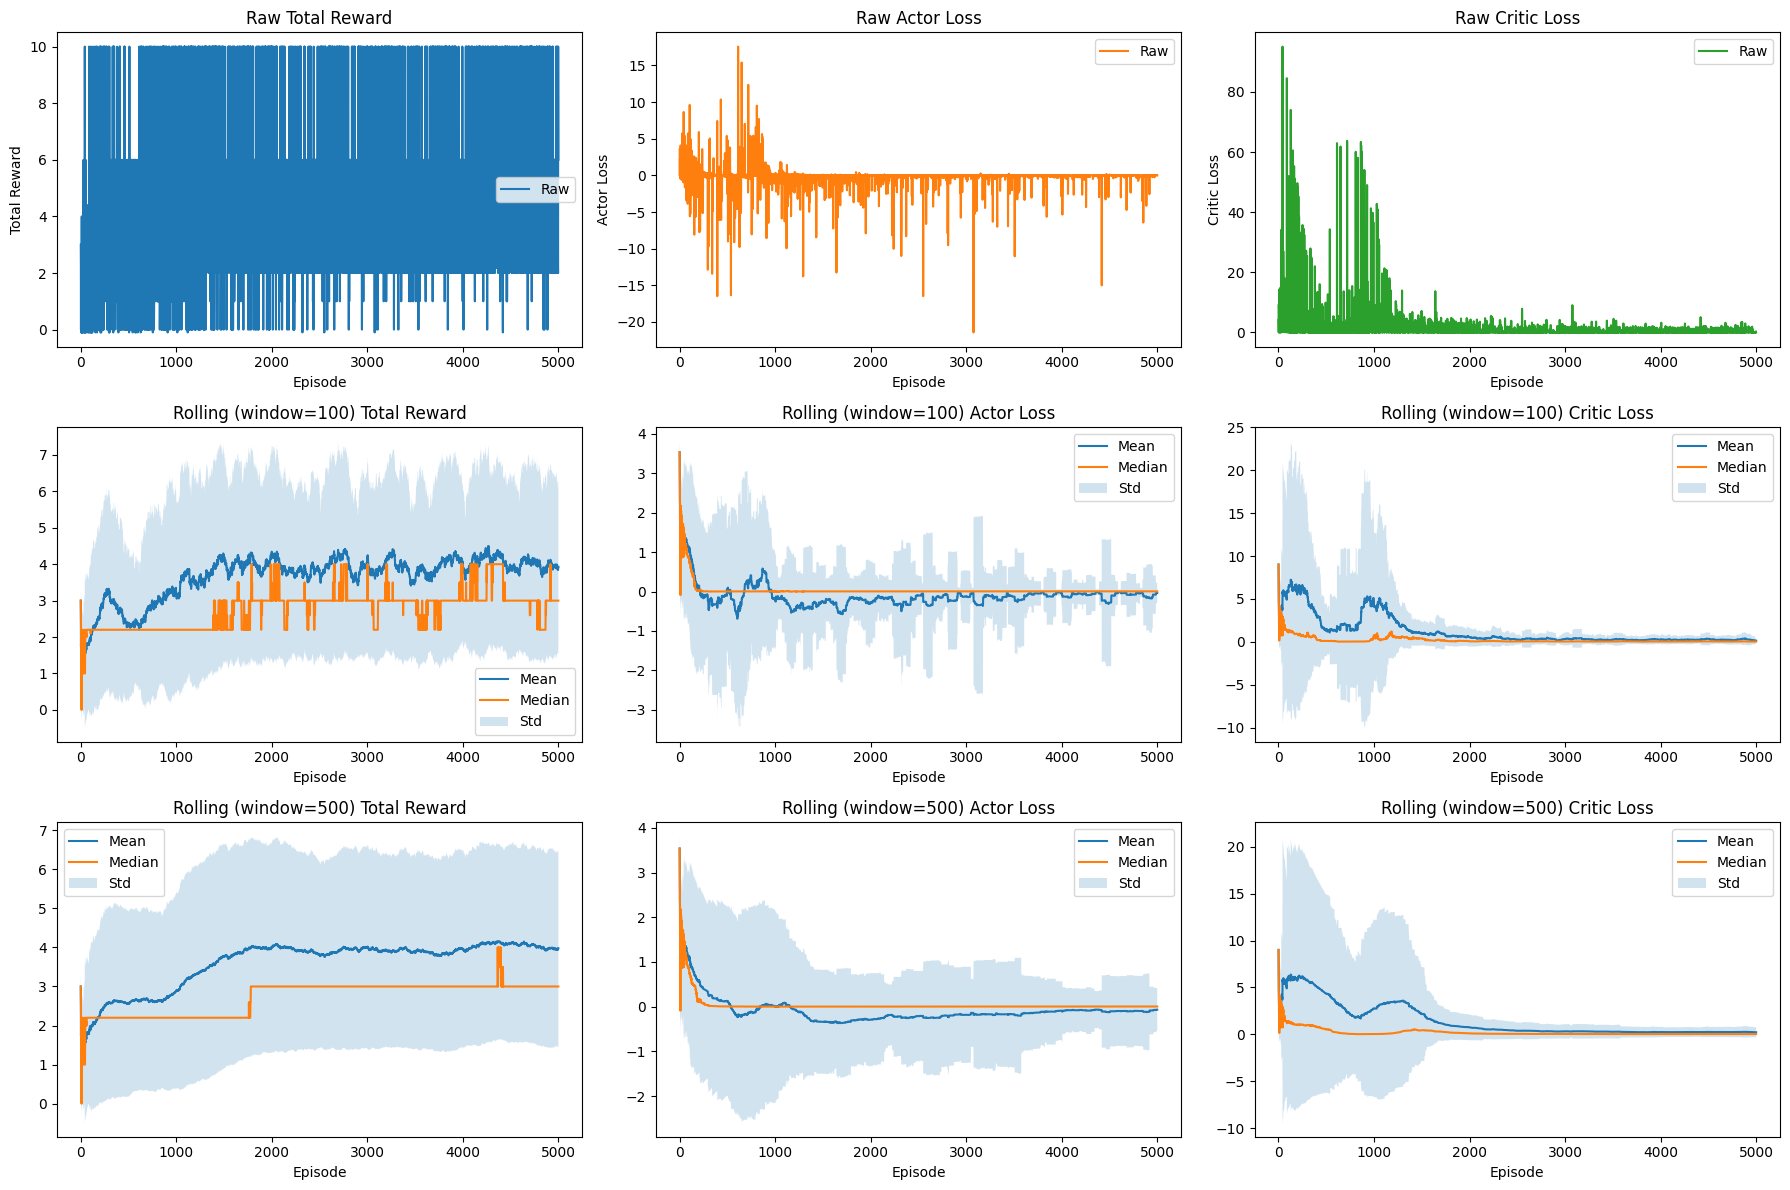

Metrics plot displayed.
Firing rate data not available (models might be Dense or logging was disabled/failed).

  Plotting Psychometric Curve for this stage...


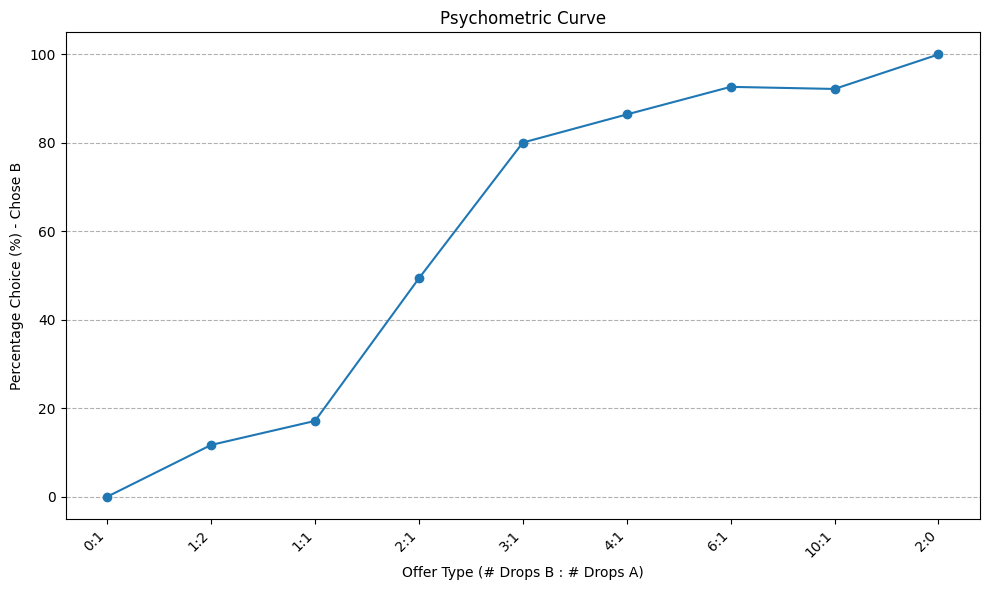

Closing the environment...
Environment closed.


In [1]:
# --- Imports ---
import os
import sys
import gymnasium as gym
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

# --- GPU Configuration ---
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

# --- Add Modules directory to Python path ---
module_path = os.path.abspath(os.path.join('.', 'Modules'))

if module_path not in sys.path:
    sys.path.append(module_path)
    print(f"Added '{module_path}' to sys.path")
else:
    print(f"'{module_path}' already in sys.path")

# --- Import custom modules ---
from env_economic_choice_randomA import EconomicChoiceEnv
from actor_critic import ActorCriticAgent
from reinforce import train_agent
from helper_functions import plot_metrics, plot_firing_rates, plot_psychometric_curve

# --- Set Random Seeds ---
seed_value = 0
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
random.seed(seed_value)

print("Setup Complete.")

# --- Define Paths for Loading/Saving ---
load_weights_path = None
save_weights_path = "saved_models_80/stage4"

# Ensure save directory exists
save_dir = os.path.dirname(save_weights_path)
if save_dir and not os.path.exists(save_dir):
    os.makedirs(save_dir)
    print(f"Created directory '{save_dir}'")


# --- Training Configuration ---
config = {
    # Environment specific params
    "A_to_B_ratio": 2.2,
    "reward_B": 1,
    "abort_penalty":-0.1,

    # Agent architecture
    "actor_hidden_size": 100,
    "critic_hidden_size": 100,
    "actor_layers": 1,
    "critic_layers": 1,
    "layer_type": "Dense",
    "actor_prob_connection": 0.1,
    "critic_prob_connection": 1.0,

    # Training hyperparameters
    "actor_lr": 1e-3,
    "critic_lr": 1e-3,
    "num_episodes": 5000,
    "gamma": 1.0,
    "l2_actor": 1e-4,
    "l2_critic": 1e-4,

    # Training process  
    "print_interval": 100,
    "record_history": 1
}

print("Configuration loaded:")
for key, value in config.items():
    print(f"  {key}: {value}")

# --- Environment Setup ---
print("Creating Padoa-Schioppa environment...")
env = EconomicChoiceEnv(
    A_to_B_ratio=config["A_to_B_ratio"],
    reward_B=config["reward_B"],
    abort_penalty=config["abort_penalty"]
)

# Get observation and action space sizes from the actual environment instance
obs_size = env.observation_space.shape[0]
act_size = env.action_space.n
print(f"Observation size: {obs_size}, Action size: {act_size}")

initial_obs, initial_info = env.reset(seed=seed_value)
print(f"Environment reset. Initial info: {initial_info}")

# --- Agent Setup ---
print("Initializing Actor-Critic Agent...")
agent = ActorCriticAgent(
    obs_size=obs_size,
    act_size=act_size,
    actor_hidden_size=config["actor_hidden_size"],
    critic_hidden_size=config["critic_hidden_size"],
    actor_layers=config["actor_layers"],
    critic_layers=config["critic_layers"],
    actor_lr=config["actor_lr"],
    critic_lr=config["critic_lr"],
    actor_prob_connection=config["actor_prob_connection"],
    critic_prob_connection=config["critic_prob_connection"],
    layer_type=config["layer_type"]
)

# Load weights
if load_weights_path:
    print(f"Attempting to load weights from: {load_weights_path}")
    load_successful = agent.load_weights(load_weights_path)
    if not load_successful:
        print(f"WARNING: Failed to load weights. Starting training with initialized weights.")
else:
    print("No weights loaded (load_weights_path is None). Starting from scratch.")

print("Agent Initialized.")

# --- Training ---
print(f"Starting training for {config['num_episodes']} episodes...")

total_rewards_history, actor_loss_history, critic_loss_history, \
actor_firing_rates, critic_firing_rates,  measurements_juices = train_agent(
    env=env,
    agent=agent,
    num_episodes=config["num_episodes"],
    gamma=config["gamma"],
    print_interval=config["print_interval"],
    l2_actor=config["l2_actor"],
    l2_critic=config["l2_critic"],
    record_history=config["record_history"]
)

print("\nTraining finished.")

# Save weights
if save_weights_path:
    print(f"Saving agent weights to: {save_weights_path}")
    agent.save_weights(save_weights_path)
else:
    print("No save path specified (save_weights_path is None). Weights not saved.")

# --- Plot Training Metrics ---
print("Plotting training metrics...")
# Adjust window sizes if needed based on num_episodes
plot_metrics(
    total_rewards_history,
    actor_loss_history,
    critic_loss_history,
    window_1=max(20, config["num_episodes"] // 50),
    window_2=max(50, config["num_episodes"] // 10)
)

print("Metrics plot displayed.")

# --- Plot Firing Rates ---
if actor_firing_rates is not None and critic_firing_rates is not None:
    print("Plotting neuron firing rates...")
    plot_firing_rates(actor_firing_rates, critic_firing_rates)
    print("Firing rate plot displayed.")
# Add checks for partial data as before...
elif actor_firing_rates is not None:
     print("Plotting only Actor firing rates (Critic might be Dense or logging failed)...")
     pass # Add specific plotting if desired
elif critic_firing_rates is not None:
     print("Plotting only Critic firing rates (Actor might be Dense or logging failed)...")
     pass # Add specific plotting if desired
else:
    print("Firing rate data not available (models might be Dense or logging was disabled/failed).")

# --- Plot psychometric curves ---
print("\n  Plotting Psychometric Curve for this stage...")
plot_psychometric_curve(measurements_juices, title=f"Psychometric Curve")

# --- Close the Environment ---
print("Closing the environment...")
env.close()
print("Environment closed.")

'/mnt/c/Users/imcir/Desktop/CIENCIA DATOS/Segundo cuatrimestre/TFM/Código/Modules' already in sys.path
Setup Complete.
Configuration loaded:
  A_to_B_ratio: 2.2
  reward_B: 1
  abort_penalty: -0.1
  actor_hidden_size: 100
  critic_hidden_size: 100
  actor_layers: 1
  critic_layers: 1
  layer_type: Dense
  actor_prob_connection: 0.1
  critic_prob_connection: 1.0
  actor_lr: 0.001
  critic_lr: 0.001
  num_episodes: 10000
  gamma: 1.0
  l2_actor: 0.0001
  l2_critic: 0.0001
  print_interval: 100
  record_history: 1
Creating Padoa-Schioppa environment...
Observation size: 3, Action size: 3
Environment reset. Initial info: {'trial_nA': 1, 'trial_nB': 6, 'trial_offer_BA': (6, 1), 'trial_juice_LR': ('B', 'A'), 'nL': 6, 'nR': 1, 'reward_actual_L': 6.0, 'reward_actual_R': 2.2, 'A_to_B_ratio': 2.2, 'chosen_action': -1, 'reward': 0.0, 'action': None}
Initializing Actor-Critic Agent...
No weights loaded (load_weights_path is None). Starting from scratch.
Agent Initialized.
Starting training for 100

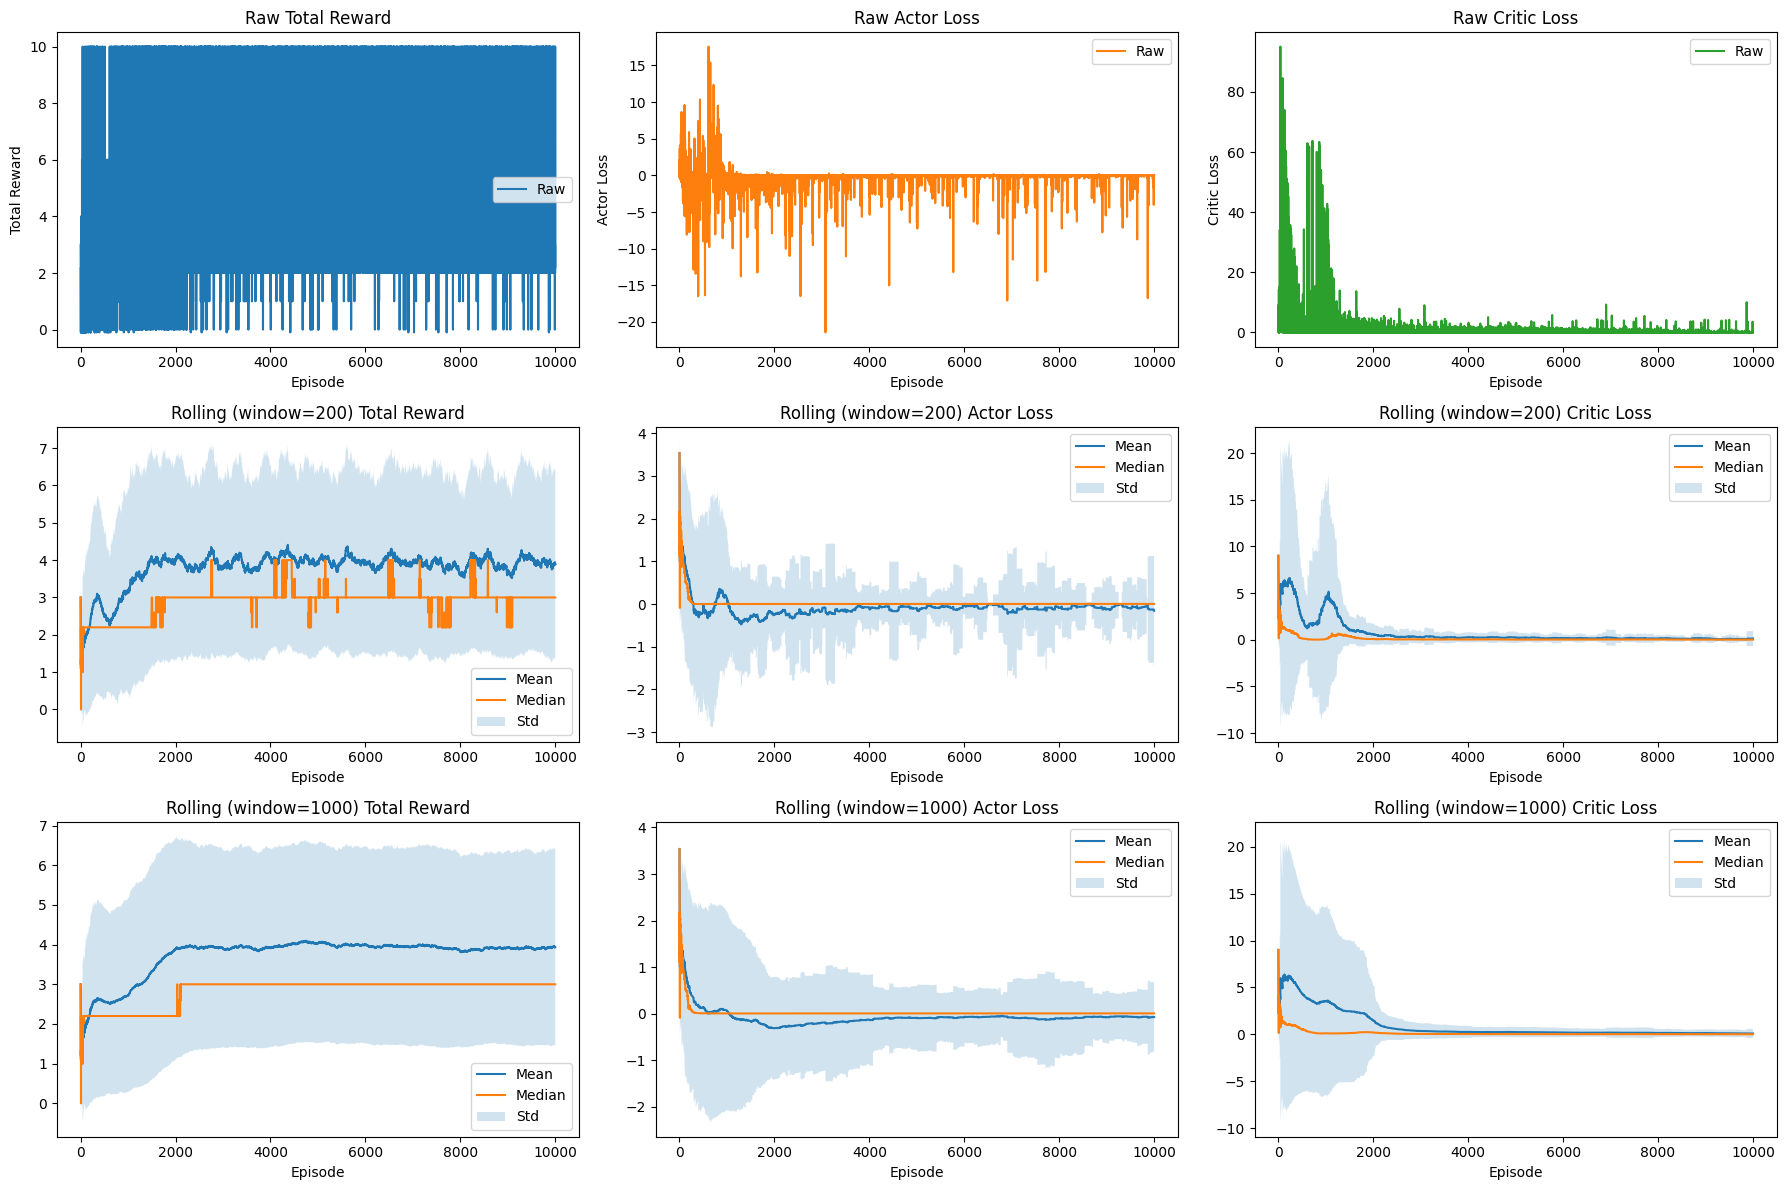

Metrics plot displayed.
Firing rate data not available (models might be Dense or logging was disabled/failed).

  Plotting Psychometric Curve for this stage...


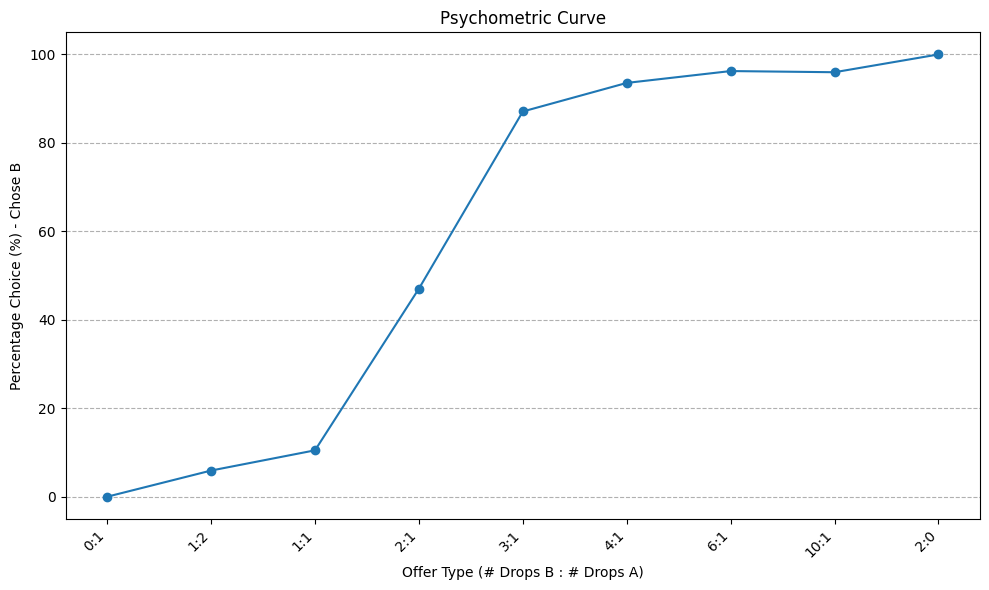

Closing the environment...
Environment closed.


In [2]:
# --- Imports ---
import os
import sys
import gymnasium as gym
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

# --- GPU Configuration ---
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

# --- Add Modules directory to Python path ---
module_path = os.path.abspath(os.path.join('.', 'Modules'))

if module_path not in sys.path:
    sys.path.append(module_path)
    print(f"Added '{module_path}' to sys.path")
else:
    print(f"'{module_path}' already in sys.path")

# --- Import custom modules ---
from env_economic_choice_randomA import EconomicChoiceEnv
from actor_critic import ActorCriticAgent
from reinforce import train_agent
from helper_functions import plot_metrics, plot_firing_rates, plot_psychometric_curve

# --- Set Random Seeds ---
seed_value = 0
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
random.seed(seed_value)

print("Setup Complete.")

# --- Define Paths for Loading/Saving ---
load_weights_path = None
save_weights_path = "saved_models_80/stage4"

# Ensure save directory exists
save_dir = os.path.dirname(save_weights_path)
if save_dir and not os.path.exists(save_dir):
    os.makedirs(save_dir)
    print(f"Created directory '{save_dir}'")


# --- Training Configuration ---
config = {
    # Environment specific params
    "A_to_B_ratio": 2.2,
    "reward_B": 1,
    "abort_penalty":-0.1,

    # Agent architecture
    "actor_hidden_size": 100,
    "critic_hidden_size": 100,
    "actor_layers": 1,
    "critic_layers": 1,
    "layer_type": "Dense",
    "actor_prob_connection": 0.1,
    "critic_prob_connection": 1.0,

    # Training hyperparameters
    "actor_lr": 1e-3,
    "critic_lr": 1e-3,
    "num_episodes": 10000,
    "gamma": 1.0,
    "l2_actor": 1e-4,
    "l2_critic": 1e-4,

    # Training process  
    "print_interval": 100,
    "record_history": 1
}

print("Configuration loaded:")
for key, value in config.items():
    print(f"  {key}: {value}")

# --- Environment Setup ---
print("Creating Padoa-Schioppa environment...")
env = EconomicChoiceEnv(
    A_to_B_ratio=config["A_to_B_ratio"],
    reward_B=config["reward_B"],
    abort_penalty=config["abort_penalty"]
)

# Get observation and action space sizes from the actual environment instance
obs_size = env.observation_space.shape[0]
act_size = env.action_space.n
print(f"Observation size: {obs_size}, Action size: {act_size}")

initial_obs, initial_info = env.reset(seed=seed_value)
print(f"Environment reset. Initial info: {initial_info}")

# --- Agent Setup ---
print("Initializing Actor-Critic Agent...")
agent = ActorCriticAgent(
    obs_size=obs_size,
    act_size=act_size,
    actor_hidden_size=config["actor_hidden_size"],
    critic_hidden_size=config["critic_hidden_size"],
    actor_layers=config["actor_layers"],
    critic_layers=config["critic_layers"],
    actor_lr=config["actor_lr"],
    critic_lr=config["critic_lr"],
    actor_prob_connection=config["actor_prob_connection"],
    critic_prob_connection=config["critic_prob_connection"],
    layer_type=config["layer_type"]
)

# Load weights
if load_weights_path:
    print(f"Attempting to load weights from: {load_weights_path}")
    load_successful = agent.load_weights(load_weights_path)
    if not load_successful:
        print(f"WARNING: Failed to load weights. Starting training with initialized weights.")
else:
    print("No weights loaded (load_weights_path is None). Starting from scratch.")

print("Agent Initialized.")

# --- Training ---
print(f"Starting training for {config['num_episodes']} episodes...")

total_rewards_history, actor_loss_history, critic_loss_history, \
actor_firing_rates, critic_firing_rates,  measurements_juices = train_agent(
    env=env,
    agent=agent,
    num_episodes=config["num_episodes"],
    gamma=config["gamma"],
    print_interval=config["print_interval"],
    l2_actor=config["l2_actor"],
    l2_critic=config["l2_critic"],
    record_history=config["record_history"]
)

print("\nTraining finished.")

# Save weights
if save_weights_path:
    print(f"Saving agent weights to: {save_weights_path}")
    agent.save_weights(save_weights_path)
else:
    print("No save path specified (save_weights_path is None). Weights not saved.")

# --- Plot Training Metrics ---
print("Plotting training metrics...")
# Adjust window sizes if needed based on num_episodes
plot_metrics(
    total_rewards_history,
    actor_loss_history,
    critic_loss_history,
    window_1=max(20, config["num_episodes"] // 50),
    window_2=max(50, config["num_episodes"] // 10)
)

print("Metrics plot displayed.")

# --- Plot Firing Rates ---
if actor_firing_rates is not None and critic_firing_rates is not None:
    print("Plotting neuron firing rates...")
    plot_firing_rates(actor_firing_rates, critic_firing_rates)
    print("Firing rate plot displayed.")
# Add checks for partial data as before...
elif actor_firing_rates is not None:
     print("Plotting only Actor firing rates (Critic might be Dense or logging failed)...")
     pass # Add specific plotting if desired
elif critic_firing_rates is not None:
     print("Plotting only Critic firing rates (Actor might be Dense or logging failed)...")
     pass # Add specific plotting if desired
else:
    print("Firing rate data not available (models might be Dense or logging was disabled/failed).")

# --- Plot psychometric curves ---
print("\n  Plotting Psychometric Curve for this stage...")
plot_psychometric_curve(measurements_juices, title=f"Psychometric Curve")

# --- Close the Environment ---
print("Closing the environment...")
env.close()
print("Environment closed.")

### FFNN economic choice fix

2025-05-01 17:58:56.126571: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746115137.601051   12425 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746115137.962077   12425 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746115141.187534   12425 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1746115141.187574   12425 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1746115141.187576   12425 computation_placer.cc:177] computation placer alr

Added '/mnt/c/Users/imcir/Desktop/CIENCIA DATOS/Segundo cuatrimestre/TFM/Código/Modules' to sys.path
Setup Complete.
Configuration loaded:
  dt: 100
  A_to_B_ratio: 2.2
  reward_B: 1
  abort_penalty: -0.1
  reward_fix_step: 0.01
  fixation_duration_ms: 30
  actor_hidden_size: 100
  critic_hidden_size: 100
  actor_layers: 1
  critic_layers: 1
  layer_type: Dense
  actor_prob_connection: 0.1
  critic_prob_connection: 1.0
  actor_lr: 0.001
  critic_lr: 0.001
  num_episodes: 10000
  gamma: 1.0
  l2_actor: 0.0001
  l2_critic: 0.0001
  print_interval: 100
  record_history: 1
Creating Padoa-Schioppa environment...
Observation size: 4, Action size: 3
Environment reset. Initial info: {'step': 0, 'epoch': 'fixation', 'fixation_steps_required': 5, 'trial_nA': 1, 'trial_nB': 6, 'trial_offer_BA': (6, 1), 'trial_juice_LR': ('B', 'A'), 'nL': 6, 'nR': 1, 'reward_actual_L': 6.0, 'reward_actual_R': 2.2, 'A_to_B_ratio': 2.2, 'chosen_action': -1, 'is_correct_choice': None, 'reward': 0.0, 'action': None}
I

2025-05-01 18:00:23.836578: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


No weights loaded (load_weights_path is None). Starting from scratch.
Agent Initialized.
Starting training for 10000 episodes...
Episode 100	Total Reward: -0.10	State [1.  1.  0.1 0.2]	Actor Loss: 0.0020	Critic Loss: 0.0033
Episode 200	Total Reward: -0.10	State [ 1.  -1.   0.   0.2]	Actor Loss: 0.0071	Critic Loss: 0.0028
Episode 300	Total Reward: -0.10	State [1.  1.  1.  0.1]	Actor Loss: 0.0107	Critic Loss: 0.0026
Episode 400	Total Reward: -0.10	State [1.  1.  0.2 0. ]	Actor Loss: -0.0074	Critic Loss: 0.0024
Episode 500	Total Reward: -0.10	State [ 1.  -1.   0.1  0.1]	Actor Loss: 0.0056	Critic Loss: 0.0022
Episode 600	Total Reward: -0.10	State [ 1.  -1.   0.1  0.3]	Actor Loss: -0.0020	Critic Loss: 0.0021
Episode 700	Total Reward: -0.10	State [1.  1.  0.1 0.1]	Actor Loss: -0.0017	Critic Loss: 0.0019
Episode 800	Total Reward: -0.10	State [1.  1.  0.2 0.1]	Actor Loss: -0.0486	Critic Loss: 0.0044
Episode 900	Total Reward: -0.10	State [ 1.  -1.   0.1  1. ]	Actor Loss: 0.0245	Critic Loss: 0.0

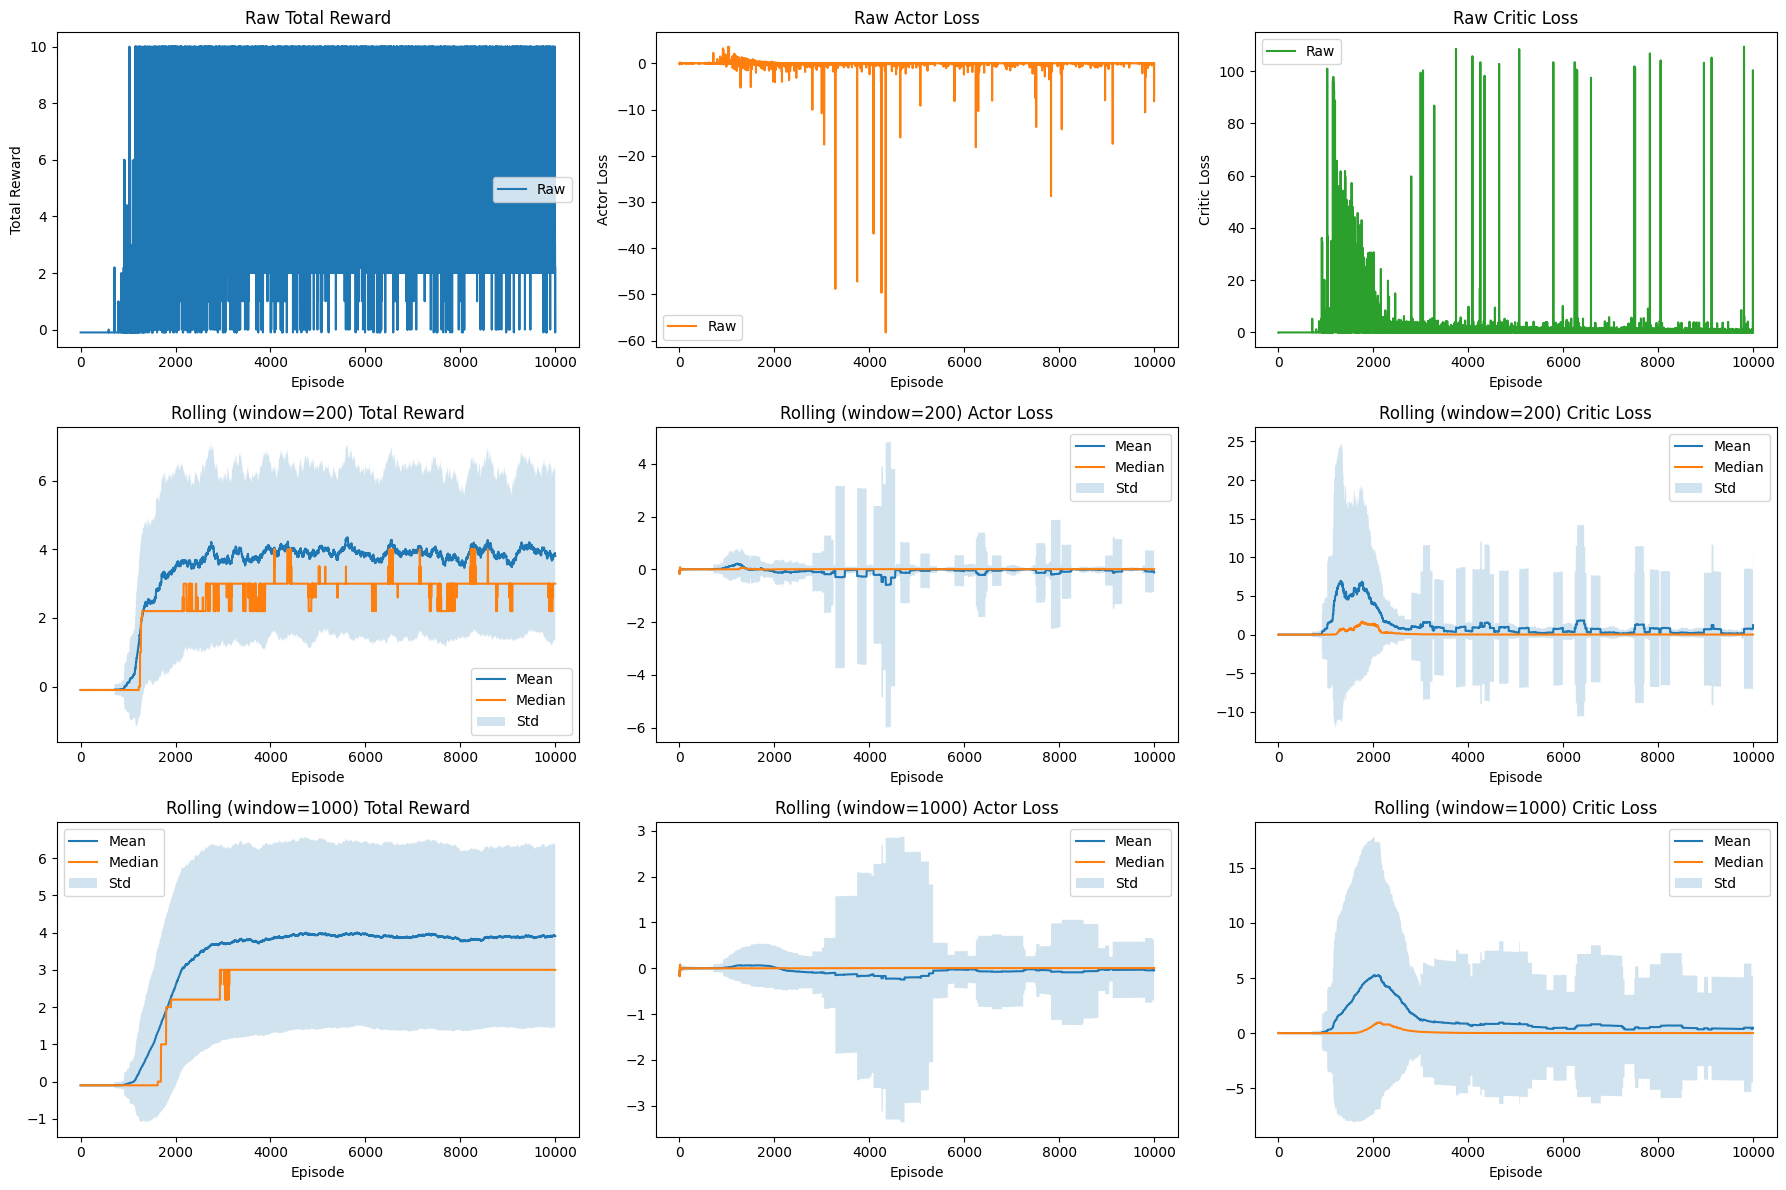

Metrics plot displayed.
Firing rate data not available (models might be Dense or logging was disabled/failed).

  Plotting Psychometric Curve for this stage...


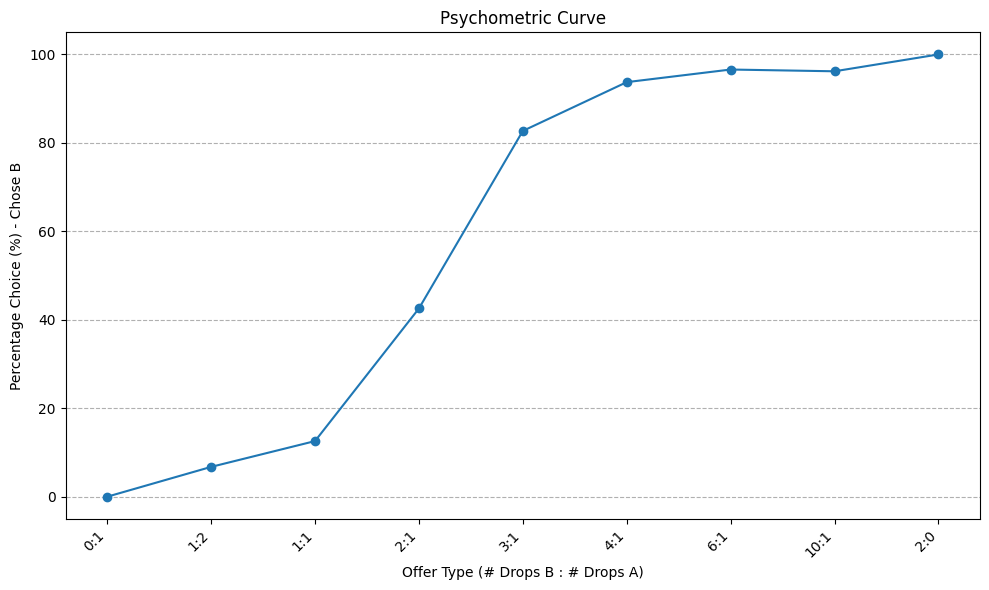

Closing the environment...
Environment closed.


In [1]:
# --- Imports ---
import os
import sys
import gymnasium as gym
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

# --- GPU Configuration ---
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

# --- Add Modules directory to Python path ---
module_path = os.path.abspath(os.path.join('.', 'Modules'))

if module_path not in sys.path:
    sys.path.append(module_path)
    print(f"Added '{module_path}' to sys.path")
else:
    print(f"'{module_path}' already in sys.path")

# --- Import custom modules ---
from env_economic_choice_fix import EconomicChoiceEnv
from actor_critic import ActorCriticAgent
from reinforce import train_agent
from helper_functions import plot_metrics, plot_firing_rates, plot_psychometric_curve

# --- Set Random Seeds ---
seed_value = 0
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
random.seed(seed_value)

print("Setup Complete.")

# --- Define Paths for Loading/Saving ---
load_weights_path = None
save_weights_path = "saved_models_80/stage4"

# Ensure save directory exists
save_dir = os.path.dirname(save_weights_path)
if save_dir and not os.path.exists(save_dir):
    os.makedirs(save_dir)
    print(f"Created directory '{save_dir}'")


# --- Training Configuration ---
config = {
    # Environment specific params
    "dt": 100,
    "A_to_B_ratio": 2.2,
    "reward_B": 1,
    "abort_penalty":-0.1,
    "reward_fix_step": 0.01,
    "fixation_duration_ms": 30,

    # Agent architecture
    "actor_hidden_size": 100,
    "critic_hidden_size": 100,
    "actor_layers": 1,
    "critic_layers": 1,
    "layer_type": "Dense",
    "actor_prob_connection": 0.1,
    "critic_prob_connection": 1.0,

    # Training hyperparameters
    "actor_lr": 1e-3,
    "critic_lr": 1e-3,
    "num_episodes": 10000,
    "gamma": 1.0,
    "l2_actor": 1e-4,
    "l2_critic": 1e-4,

    # Training process  
    "print_interval": 100,
    "record_history": 1
}

print("Configuration loaded:")
for key, value in config.items():
    print(f"  {key}: {value}")

# --- Environment Setup ---
print("Creating Padoa-Schioppa environment...")
env = EconomicChoiceEnv(
    A_to_B_ratio=config["A_to_B_ratio"],
    reward_B=config["reward_B"],
    abort_penalty=config["abort_penalty"]
)

# Get observation and action space sizes from the actual environment instance
obs_size = env.observation_space.shape[0]
act_size = env.action_space.n
print(f"Observation size: {obs_size}, Action size: {act_size}")

initial_obs, initial_info = env.reset(seed=seed_value)
print(f"Environment reset. Initial info: {initial_info}")

# --- Agent Setup ---
print("Initializing Actor-Critic Agent...")
agent = ActorCriticAgent(
    obs_size=obs_size,
    act_size=act_size,
    actor_hidden_size=config["actor_hidden_size"],
    critic_hidden_size=config["critic_hidden_size"],
    actor_layers=config["actor_layers"],
    critic_layers=config["critic_layers"],
    actor_lr=config["actor_lr"],
    critic_lr=config["critic_lr"],
    actor_prob_connection=config["actor_prob_connection"],
    critic_prob_connection=config["critic_prob_connection"],
    layer_type=config["layer_type"]
)

# Load weights
if load_weights_path:
    print(f"Attempting to load weights from: {load_weights_path}")
    load_successful = agent.load_weights(load_weights_path)
    if not load_successful:
        print(f"WARNING: Failed to load weights. Starting training with initialized weights.")
else:
    print("No weights loaded (load_weights_path is None). Starting from scratch.")

print("Agent Initialized.")

# --- Training ---
print(f"Starting training for {config['num_episodes']} episodes...")

total_rewards_history, actor_loss_history, critic_loss_history, \
actor_firing_rates, critic_firing_rates,  measurements_juices = train_agent(
    env=env,
    agent=agent,
    num_episodes=config["num_episodes"],
    gamma=config["gamma"],
    print_interval=config["print_interval"],
    l2_actor=config["l2_actor"],
    l2_critic=config["l2_critic"],
    record_history=config["record_history"]
)

print("\nTraining finished.")

# Save weights
if save_weights_path:
    print(f"Saving agent weights to: {save_weights_path}")
    agent.save_weights(save_weights_path)
else:
    print("No save path specified (save_weights_path is None). Weights not saved.")

# --- Plot Training Metrics ---
print("Plotting training metrics...")
# Adjust window sizes if needed based on num_episodes
plot_metrics(
    total_rewards_history,
    actor_loss_history,
    critic_loss_history,
    window_1=max(20, config["num_episodes"] // 50),
    window_2=max(50, config["num_episodes"] // 10)
)

print("Metrics plot displayed.")

# --- Plot Firing Rates ---
if actor_firing_rates is not None and critic_firing_rates is not None:
    print("Plotting neuron firing rates...")
    plot_firing_rates(actor_firing_rates, critic_firing_rates)
    print("Firing rate plot displayed.")
# Add checks for partial data as before...
elif actor_firing_rates is not None:
     print("Plotting only Actor firing rates (Critic might be Dense or logging failed)...")
     pass # Add specific plotting if desired
elif critic_firing_rates is not None:
     print("Plotting only Critic firing rates (Actor might be Dense or logging failed)...")
     pass # Add specific plotting if desired
else:
    print("Firing rate data not available (models might be Dense or logging was disabled/failed).")

# --- Plot psychometric curves ---
print("\n  Plotting Psychometric Curve for this stage...")
plot_psychometric_curve(measurements_juices, title=f"Psychometric Curve")

# --- Close the Environment ---
print("Closing the environment...")
env.close()
print("Environment closed.")

### FFNN economic choice full (no holding choice)

2025-05-01 18:45:22.012980: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746117923.750503   13151 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746117924.225784   13151 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746117926.822698   13151 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1746117926.822785   13151 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1746117926.822787   13151 computation_placer.cc:177] computation placer alr

Added '/mnt/c/Users/imcir/Desktop/CIENCIA DATOS/Segundo cuatrimestre/TFM/Código/Modules' to sys.path
Setup Complete.
Configuration loaded:
  dt: 10
  A_to_B_ratio: 2.2
  reward_B: 1
  abort_penalty: -0.1
  input_noise_sigma: 0.0
  reward_fixation: 0.01
  reward_go_fixation: -0.01
  duration_params: [30, 30, 70, 70]
  actor_hidden_size: 100
  critic_hidden_size: 100
  actor_layers: 1
  critic_layers: 1
  layer_type: Dense
  actor_prob_connection: 0.1
  critic_prob_connection: 1.0
  actor_lr: 0.001
  critic_lr: 0.001
  num_episodes: 10000
  gamma: 1.0
  l2_actor: 0.0001
  l2_critic: 0.0001
  print_interval: 100
  record_history: 1
Creating Padoa-Schioppa environment...
Observation size: 4, Action size: 3
Environment reset. Initial info: {'step': 0, 'epoch': 'fixation', 'juice_LR': ('B', 'A'), 'offer_BA': (6, 1), 'nL': 6, 'nR': 1, 'rL': 6.0, 'rR': 2.2, 'chosen_action': -1, 'choice_time_step': -1, 'is_correct_choice': None, 'A_to_B_ratio': 2.2, 'rewards_cfg': {'fix_step': 0.01, 'go_fix_ste

2025-05-01 18:46:20.732526: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


No weights loaded (load_weights_path is None). Starting from scratch.
Agent Initialized.
Starting training for 10000 episodes...
Episode 100	Total Reward: -0.10	State [1. 0. 0. 0.]	Actor Loss: -0.0185	Critic Loss: 0.0027
Episode 200	Total Reward: -0.08	State [1. 0. 0. 0.]	Actor Loss: -0.0488	Critic Loss: 0.0044
Episode 300	Total Reward: 1.07	State [0.  1.  0.1 0.1]	Actor Loss: 0.1421	Critic Loss: 0.1558
Episode 400	Total Reward: 2.27	State [0.  1.  0.2 0.1]	Actor Loss: 0.0880	Critic Loss: 0.0770
Episode 500	Total Reward: 2.26	State [ 0.  -1.   0.1  0.3]	Actor Loss: 0.0200	Critic Loss: 0.0331
Episode 600	Total Reward: 2.26	State [ 0.  -1.   0.1  0.3]	Actor Loss: 0.0338	Critic Loss: 0.0568
Episode 700	Total Reward: 2.29	State [0.  1.  1.  0.1]	Actor Loss: -0.0474	Critic Loss: 0.1986
Episode 800	Total Reward: 2.29	State [0.  1.  0.4 0.1]	Actor Loss: -0.0082	Critic Loss: 0.0135
Episode 900	Total Reward: 1.10	State [ 0.  -1.   0.1  0.1]	Actor Loss: -0.0898	Critic Loss: 0.7633
Episode 1000	T

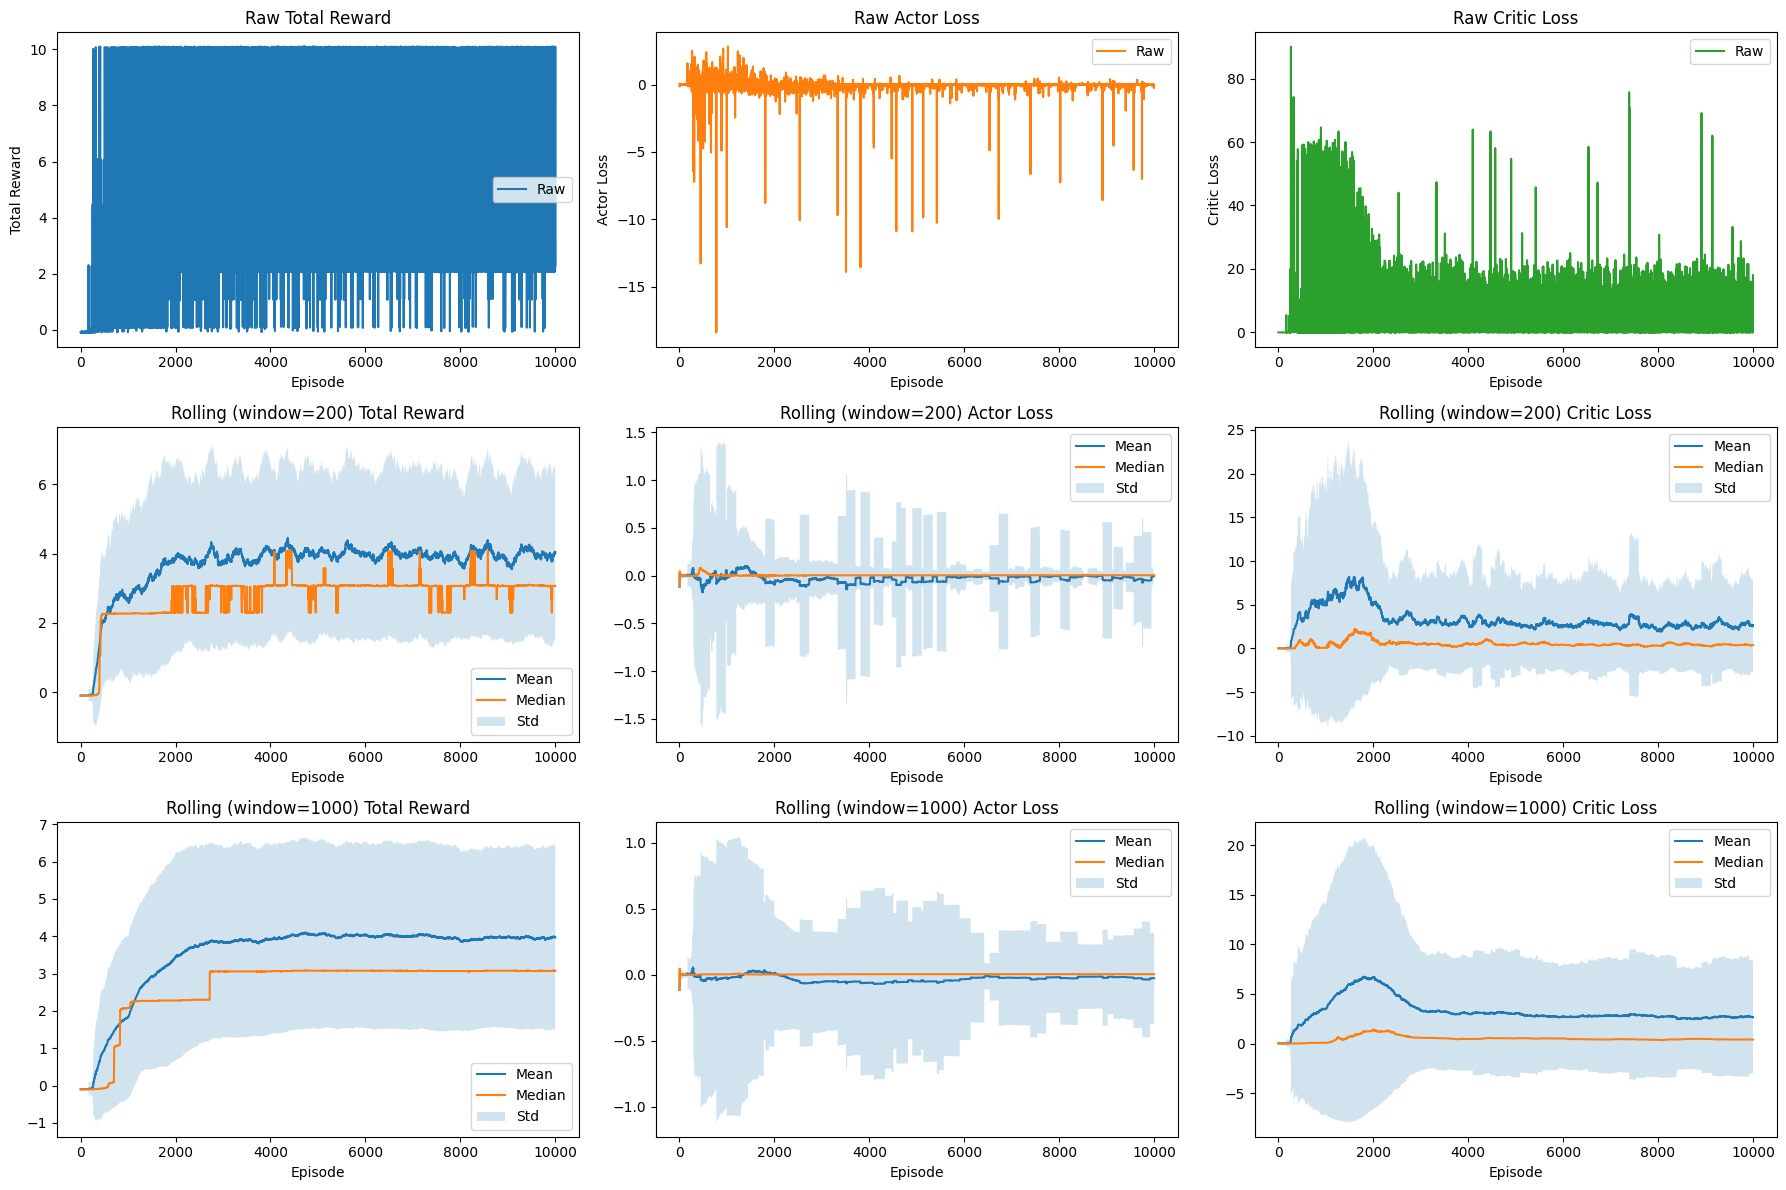

Metrics plot displayed.
Firing rate data not available (models might be Dense or logging was disabled/failed).

  Plotting Psychometric Curve for this stage...


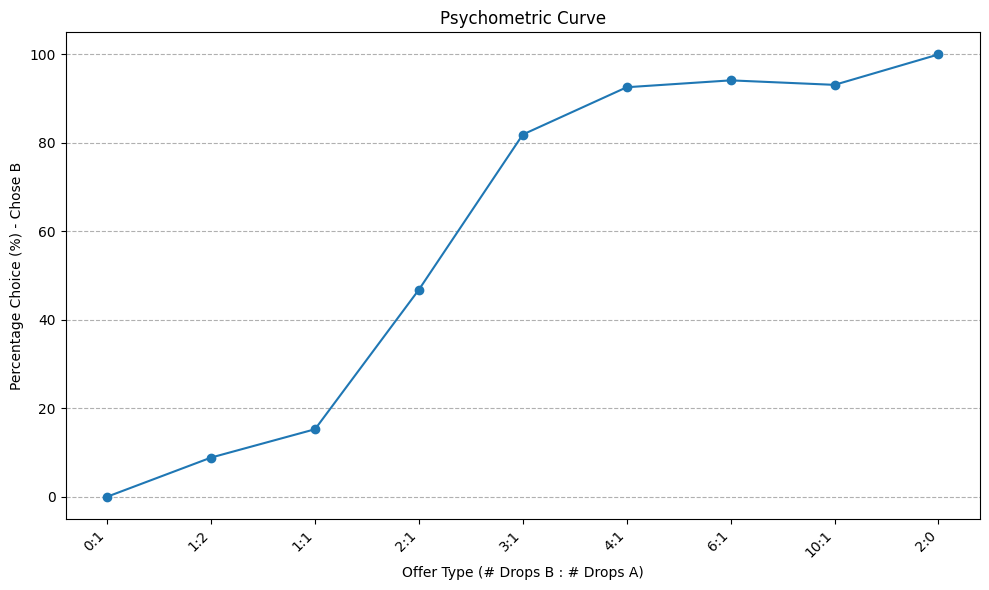

Closing the environment...
Environment closed.


In [1]:
# --- Imports ---
import os
import sys
import gymnasium as gym
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

# --- GPU Configuration ---
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

# --- Add Modules directory to Python path ---
module_path = os.path.abspath(os.path.join('.', 'Modules'))

if module_path not in sys.path:
    sys.path.append(module_path)
    print(f"Added '{module_path}' to sys.path")
else:
    print(f"'{module_path}' already in sys.path")

# --- Import custom modules ---
from env_economic_choice_no_hold import EconomicChoiceEnv
from actor_critic import ActorCriticAgent
from reinforce import train_agent
from helper_functions import plot_metrics, plot_firing_rates, plot_psychometric_curve

# --- Set Random Seeds ---
seed_value = 0
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
random.seed(seed_value)

print("Setup Complete.")

# --- Define Paths for Loading/Saving ---
load_weights_path = None
save_weights_path = "saved_models_80/stage4"

# Ensure save directory exists
save_dir = os.path.dirname(save_weights_path)
if save_dir and not os.path.exists(save_dir):
    os.makedirs(save_dir)
    print(f"Created directory '{save_dir}'")


# --- Training Configuration ---
config = {
    # Environment specific params
    "dt": 10,
    "A_to_B_ratio": 2.2,
    "reward_B": 1,
    "abort_penalty":-0.1,
    "input_noise_sigma": 0.0,
    "reward_fixation": 0.01,
    "reward_go_fixation": -0.01,
    "duration_params": [30, 30, 70, 70],

    # Agent architecture
    "actor_hidden_size": 100,
    "critic_hidden_size": 100,
    "actor_layers": 1,
    "critic_layers": 1,
    "layer_type": "Dense",
    "actor_prob_connection": 0.1,
    "critic_prob_connection": 1.0,

    # Training hyperparameters
    "actor_lr": 1e-3,
    "critic_lr": 1e-3,
    "num_episodes": 10000,
    "gamma": 1.0,
    "l2_actor": 1e-4,
    "l2_critic": 1e-4,

    # Training process  
    "print_interval": 100,
    "record_history": 1
}

print("Configuration loaded:")
for key, value in config.items():
    print(f"  {key}: {value}")

# --- Environment Setup ---
print("Creating Padoa-Schioppa environment...")
env = EconomicChoiceEnv(
    dt=config["dt"],
    A_to_B_ratio=config["A_to_B_ratio"],
    reward_B=config["reward_B"],
    abort_penalty=config["abort_penalty"],
    input_noise_sigma=config["input_noise_sigma"],
    reward_fixation=config["reward_fixation"],
    reward_go_fixation=config["reward_go_fixation"],
    duration_params=config["duration_params"]
)

# Get observation and action space sizes from the actual environment instance
obs_size = env.observation_space.shape[0]
act_size = env.action_space.n
print(f"Observation size: {obs_size}, Action size: {act_size}")

initial_obs, initial_info = env.reset(seed=seed_value)
print(f"Environment reset. Initial info: {initial_info}")

# --- Agent Setup ---
print("Initializing Actor-Critic Agent...")
agent = ActorCriticAgent(
    obs_size=obs_size,
    act_size=act_size,
    actor_hidden_size=config["actor_hidden_size"],
    critic_hidden_size=config["critic_hidden_size"],
    actor_layers=config["actor_layers"],
    critic_layers=config["critic_layers"],
    actor_lr=config["actor_lr"],
    critic_lr=config["critic_lr"],
    actor_prob_connection=config["actor_prob_connection"],
    critic_prob_connection=config["critic_prob_connection"],
    layer_type=config["layer_type"]
)

# Load weights
if load_weights_path:
    print(f"Attempting to load weights from: {load_weights_path}")
    load_successful = agent.load_weights(load_weights_path)
    if not load_successful:
        print(f"WARNING: Failed to load weights. Starting training with initialized weights.")
else:
    print("No weights loaded (load_weights_path is None). Starting from scratch.")

print("Agent Initialized.")

# --- Training ---
print(f"Starting training for {config['num_episodes']} episodes...")

total_rewards_history, actor_loss_history, critic_loss_history, \
actor_firing_rates, critic_firing_rates,  measurements_juices = train_agent(
    env=env,
    agent=agent,
    num_episodes=config["num_episodes"],
    gamma=config["gamma"],
    print_interval=config["print_interval"],
    l2_actor=config["l2_actor"],
    l2_critic=config["l2_critic"],
    record_history=config["record_history"]
)

print("\nTraining finished.")

# Save weights
if save_weights_path:
    print(f"Saving agent weights to: {save_weights_path}")
    agent.save_weights(save_weights_path)
else:
    print("No save path specified (save_weights_path is None). Weights not saved.")

# --- Plot Training Metrics ---
print("Plotting training metrics...")
# Adjust window sizes if needed based on num_episodes
plot_metrics(
    total_rewards_history,
    actor_loss_history,
    critic_loss_history,
    window_1=max(20, config["num_episodes"] // 50),
    window_2=max(50, config["num_episodes"] // 10)
)

print("Metrics plot displayed.")

# --- Plot Firing Rates ---
if actor_firing_rates is not None and critic_firing_rates is not None:
    print("Plotting neuron firing rates...")
    plot_firing_rates(actor_firing_rates, critic_firing_rates)
    print("Firing rate plot displayed.")
# Add checks for partial data as before...
elif actor_firing_rates is not None:
     print("Plotting only Actor firing rates (Critic might be Dense or logging failed)...")
     pass # Add specific plotting if desired
elif critic_firing_rates is not None:
     print("Plotting only Critic firing rates (Actor might be Dense or logging failed)...")
     pass # Add specific plotting if desired
else:
    print("Firing rate data not available (models might be Dense or logging was disabled/failed).")

# --- Plot psychometric curves ---
print("\n  Plotting Psychometric Curve for this stage...")
plot_psychometric_curve(measurements_juices, title=f"Psychometric Curve")

# --- Close the Environment ---
print("Closing the environment...")
env.close()
print("Environment closed.")

2025-05-07 19:12:19.189285: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746637941.648791   21212 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746637942.331619   21212 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746637947.633363   21212 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1746637947.633478   21212 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1746637947.633480   21212 computation_placer.cc:177] computation placer alr

Added '/mnt/c/Users/imcir/Desktop/CIENCIA DATOS/Segundo cuatrimestre/TFM/Código/Modules' to sys.path
Setup Complete.
Configuration loaded:
  dt: 10
  A_to_B_ratio: 2.2
  reward_B: 25
  abort_penalty: -0.1
  input_noise_sigma: 0.0
  reward_fixation: 0.01
  reward_go_fixation: -0.01
  duration_params: [150, 100, 200, 200]
  actor_hidden_size: 100
  critic_hidden_size: 100
  actor_layers: 1
  critic_layers: 1
  layer_type: Dense
  actor_prob_connection: 0.1
  critic_prob_connection: 1.0
  actor_lr: 0.0005
  critic_lr: 0.0005
  num_episodes: 5000
  gamma: 1.0
  l2_actor: 0.0001
  l2_critic: 0.0001
  print_interval: 100
  record_history: 1
Creating Padoa-Schioppa environment...
Observation size: 4, Action size: 3
Environment reset. Initial info: {'step': 0, 'epoch': 'fixation', 'juice_LR': ('B', 'A'), 'offer_BA': (6, 1), 'nL': 6, 'nR': 1, 'rL': 150.0, 'rR': 55.00000000000001, 'chosen_action': -1, 'choice_time_step': -1, 'is_correct_choice': None, 'A_to_B_ratio': 2.2, 'rewards_cfg': {'fix_st

2025-05-07 19:13:25.685708: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


No weights loaded (load_weights_path is None). Starting from scratch.
Agent Initialized.
Starting training for 5000 episodes...
Episode 100	Total Reward: -0.10	State [1. 0. 0. 0.]	Actor Loss: -0.0042	Critic Loss: 0.0032
Episode 200	Total Reward: -0.10	State [1. 0. 0. 0.]	Actor Loss: 0.0019	Critic Loss: 0.0021
Episode 300	Total Reward: -0.08	State [1. 0. 0. 0.]	Actor Loss: 0.0020	Critic Loss: 0.0018
Episode 400	Total Reward: 55.25	State [0.  1.  0.2 0.1]	Actor Loss: 6.2454	Critic Loss: 2999.0115
Episode 500	Total Reward: 55.24	State [ 0.  -1.   0.1  0.3]	Actor Loss: 5.0638	Critic Loss: 2420.2112
Episode 600	Total Reward: 55.25	State [ 0.  -1.   0.1  0.3]	Actor Loss: 2.8536	Critic Loss: 810.4225
Episode 700	Total Reward: 55.29	State [0.  1.  1.  0.1]	Actor Loss: 1.3963	Critic Loss: 115.7868
Episode 800	Total Reward: 55.30	State [0.  1.  0.4 0.1]	Actor Loss: 2.0152	Critic Loss: 76.0960
Episode 900	Total Reward: 25.28	State [ 0.  -1.   0.1  0.1]	Actor Loss: -0.6480	Critic Loss: 552.7024
Ep

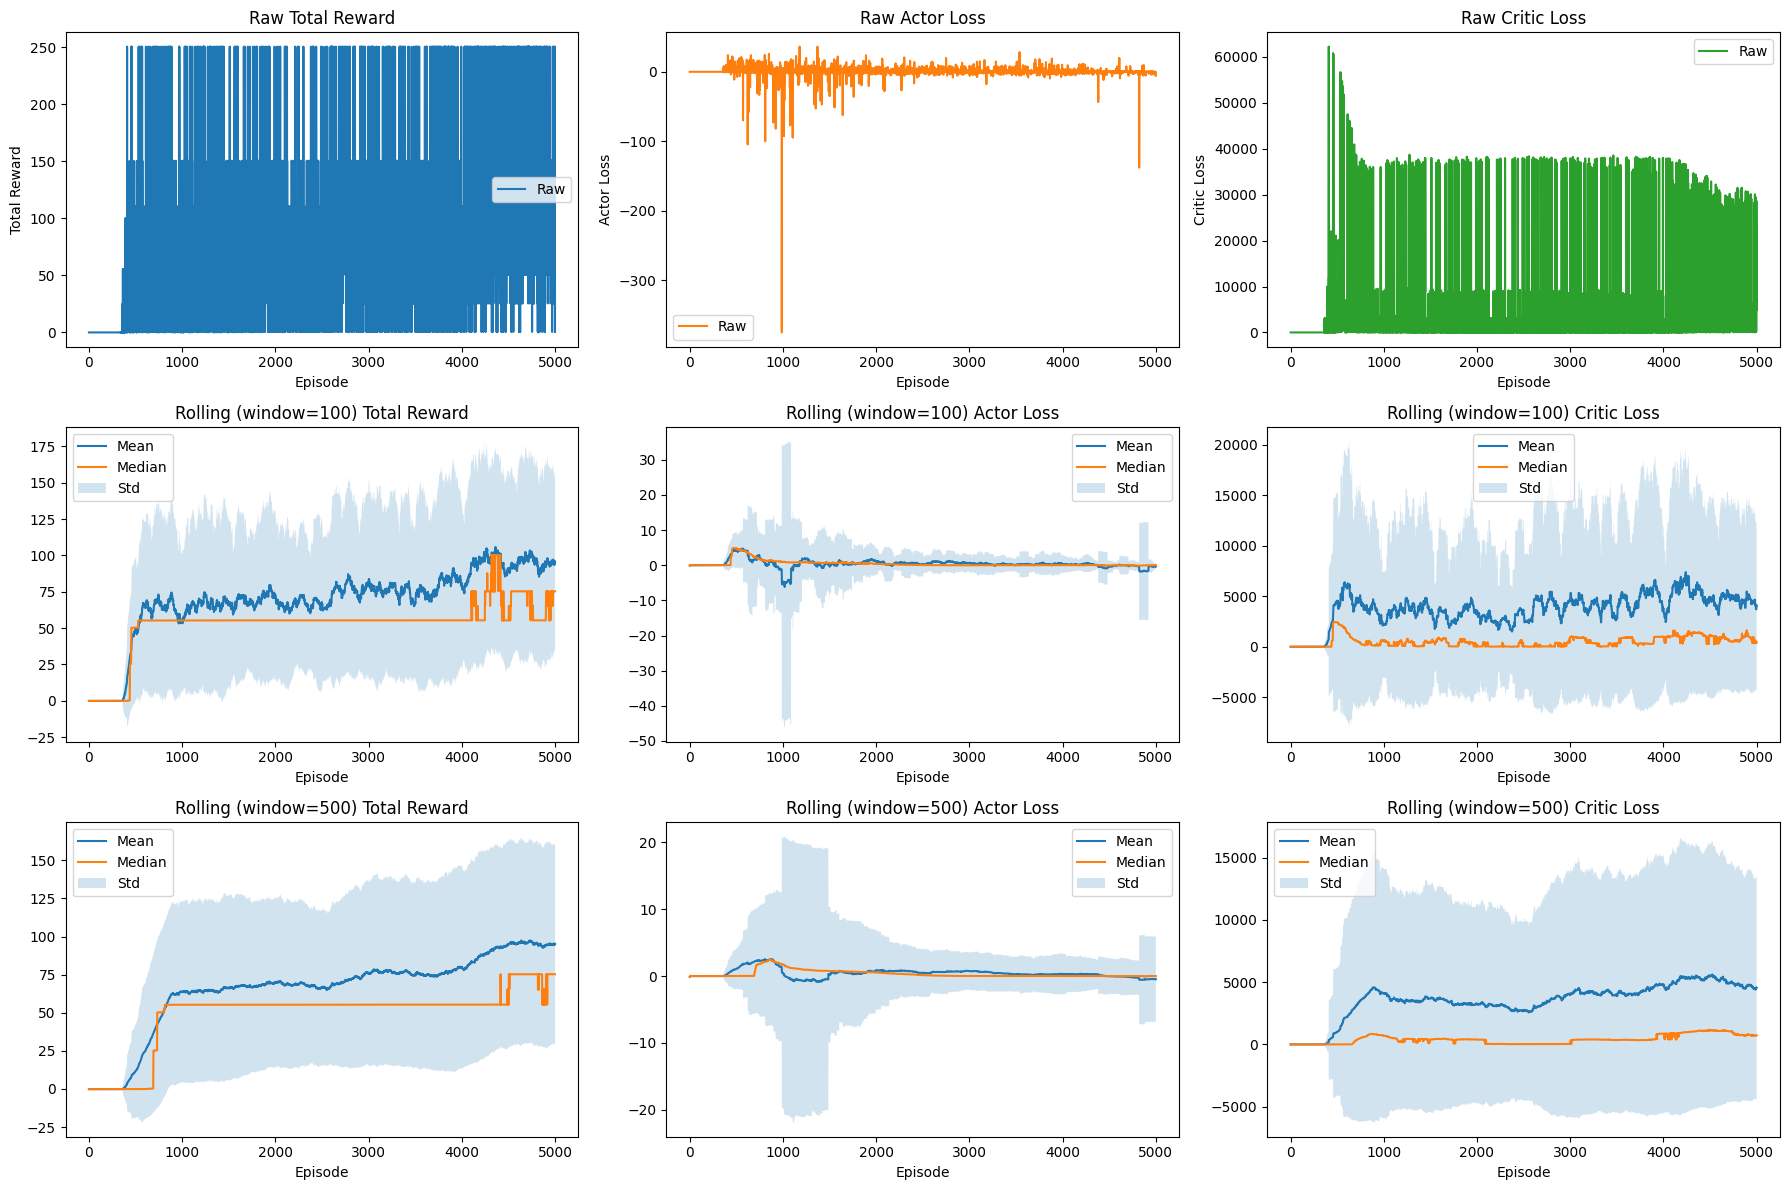

Metrics plot displayed.
Firing rate data not available (models might be Dense or logging was disabled/failed).

  Plotting Psychometric Curve for this stage...


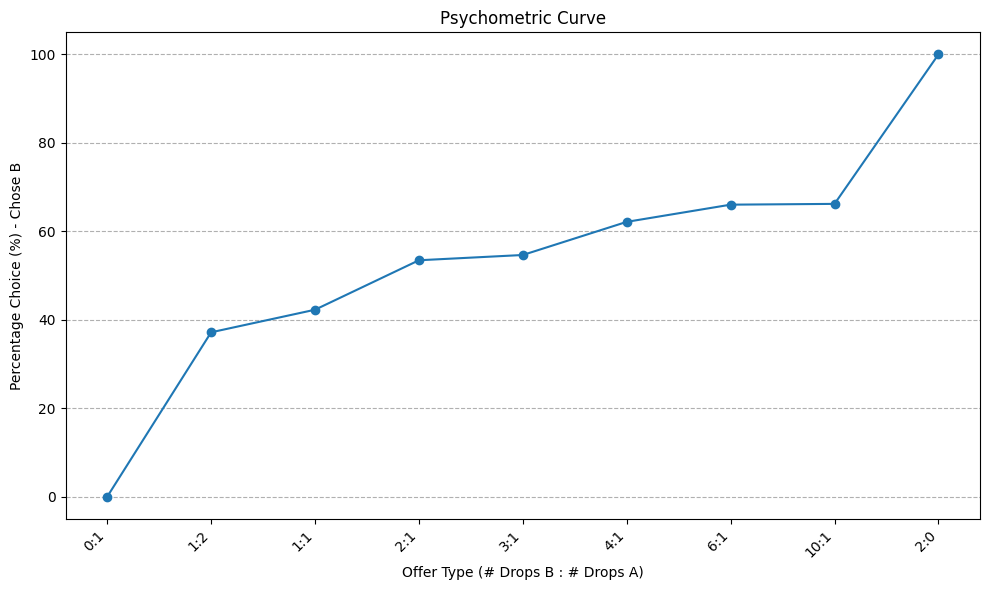

Closing the environment...
Environment closed.


In [1]:
# --- Imports ---
import os
import sys
import gymnasium as gym
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

# --- GPU Configuration ---
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

# --- Add Modules directory to Python path ---
module_path = os.path.abspath(os.path.join('.', 'Modules'))

if module_path not in sys.path:
    sys.path.append(module_path)
    print(f"Added '{module_path}' to sys.path")
else:
    print(f"'{module_path}' already in sys.path")

# --- Import custom modules ---
from env_economic_choice_no_hold import EconomicChoiceEnv
from actor_critic import ActorCriticAgent
from reinforce import train_agent
from helper_functions import plot_metrics, plot_firing_rates, plot_psychometric_curve

# --- Set Random Seeds ---
seed_value = 0
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
random.seed(seed_value)

print("Setup Complete.")

# --- Define Paths for Loading/Saving ---
load_weights_path = None
save_weights_path = "saved_models_80/stage4"

# Ensure save directory exists
save_dir = os.path.dirname(save_weights_path)
if save_dir and not os.path.exists(save_dir):
    os.makedirs(save_dir)
    print(f"Created directory '{save_dir}'")


# --- Training Configuration ---
config = {
    # Environment specific params
    "dt": 10,
    "A_to_B_ratio": 2.2,
    "reward_B": 25,
    "abort_penalty":-0.1,
    "input_noise_sigma": 0.0,
    "reward_fixation": 0.01,
    "reward_go_fixation": -0.01,
    "duration_params": [150, 100, 200, 200],

    # Agent architecture
    "actor_hidden_size": 100,
    "critic_hidden_size": 100,
    "actor_layers": 1,
    "critic_layers": 1,
    "layer_type": "Dense",
    "actor_prob_connection": 0.1,
    "critic_prob_connection": 1.0,

    # Training hyperparameters
    "actor_lr": 5e-4,
    "critic_lr": 5e-4,
    "num_episodes": 5000,
    "gamma": 1.0,
    "l2_actor": 1e-4,
    "l2_critic": 1e-4,

    # Training process  
    "print_interval": 100,
    "record_history": 1
}

print("Configuration loaded:")
for key, value in config.items():
    print(f"  {key}: {value}")

# --- Environment Setup ---
print("Creating Padoa-Schioppa environment...")
env = EconomicChoiceEnv(
    dt=config["dt"],
    A_to_B_ratio=config["A_to_B_ratio"],
    reward_B=config["reward_B"],
    abort_penalty=config["abort_penalty"],
    input_noise_sigma=config["input_noise_sigma"],
    reward_fixation=config["reward_fixation"],
    reward_go_fixation=config["reward_go_fixation"],
    duration_params=config["duration_params"]
)

# Get observation and action space sizes from the actual environment instance
obs_size = env.observation_space.shape[0]
act_size = env.action_space.n
print(f"Observation size: {obs_size}, Action size: {act_size}")

initial_obs, initial_info = env.reset(seed=seed_value)
print(f"Environment reset. Initial info: {initial_info}")

# --- Agent Setup ---
print("Initializing Actor-Critic Agent...")
agent = ActorCriticAgent(
    obs_size=obs_size,
    act_size=act_size,
    actor_hidden_size=config["actor_hidden_size"],
    critic_hidden_size=config["critic_hidden_size"],
    actor_layers=config["actor_layers"],
    critic_layers=config["critic_layers"],
    actor_lr=config["actor_lr"],
    critic_lr=config["critic_lr"],
    actor_prob_connection=config["actor_prob_connection"],
    critic_prob_connection=config["critic_prob_connection"],
    layer_type=config["layer_type"]
)

# Load weights
if load_weights_path:
    print(f"Attempting to load weights from: {load_weights_path}")
    load_successful = agent.load_weights(load_weights_path)
    if not load_successful:
        print(f"WARNING: Failed to load weights. Starting training with initialized weights.")
else:
    print("No weights loaded (load_weights_path is None). Starting from scratch.")

print("Agent Initialized.")

# --- Training ---
print(f"Starting training for {config['num_episodes']} episodes...")

total_rewards_history, actor_loss_history, critic_loss_history, \
actor_firing_rates, critic_firing_rates,  measurements_juices = train_agent(
    env=env,
    agent=agent,
    num_episodes=config["num_episodes"],
    gamma=config["gamma"],
    print_interval=config["print_interval"],
    l2_actor=config["l2_actor"],
    l2_critic=config["l2_critic"],
    record_history=config["record_history"]
)

print("\nTraining finished.")

# Save weights
if save_weights_path:
    print(f"Saving agent weights to: {save_weights_path}")
    agent.save_weights(save_weights_path)
else:
    print("No save path specified (save_weights_path is None). Weights not saved.")

# --- Plot Training Metrics ---
print("Plotting training metrics...")
# Adjust window sizes if needed based on num_episodes
plot_metrics(
    total_rewards_history,
    actor_loss_history,
    critic_loss_history,
    window_1=max(20, config["num_episodes"] // 50),
    window_2=max(50, config["num_episodes"] // 10)
)

print("Metrics plot displayed.")

# --- Plot Firing Rates ---
if actor_firing_rates is not None and critic_firing_rates is not None:
    print("Plotting neuron firing rates...")
    plot_firing_rates(actor_firing_rates, critic_firing_rates)
    print("Firing rate plot displayed.")
# Add checks for partial data as before...
elif actor_firing_rates is not None:
     print("Plotting only Actor firing rates (Critic might be Dense or logging failed)...")
     pass # Add specific plotting if desired
elif critic_firing_rates is not None:
     print("Plotting only Critic firing rates (Actor might be Dense or logging failed)...")
     pass # Add specific plotting if desired
else:
    print("Firing rate data not available (models might be Dense or logging was disabled/failed).")

# --- Plot psychometric curves ---
print("\n  Plotting Psychometric Curve for this stage...")
plot_psychometric_curve(measurements_juices, title=f"Psychometric Curve")

# --- Close the Environment ---
print("Closing the environment...")
env.close()
print("Environment closed.")

2025-05-07 20:26:58.443206: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746642420.160495   32003 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746642420.615545   32003 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746642424.639046   32003 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1746642424.639073   32003 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1746642424.639075   32003 computation_placer.cc:177] computation placer alr

Added '/mnt/c/Users/imcir/Desktop/CIENCIA DATOS/Segundo cuatrimestre/TFM/Código/Modules' to sys.path
Setup Complete.
Configuration loaded:
  dt: 10
  A_to_B_ratio: 2.2
  reward_B: 25
  abort_penalty: -0.1
  input_noise_sigma: 0.0
  reward_fixation: 0.01
  reward_go_fixation: -0.01
  duration_params: [150, 100, 200, 200]
  actor_hidden_size: 100
  critic_hidden_size: 100
  actor_layers: 1
  critic_layers: 1
  layer_type: Dense
  actor_prob_connection: 0.1
  critic_prob_connection: 1.0
  actor_lr: 0.0005
  critic_lr: 0.0005
  num_episodes: 6400
  gamma: 1.0
  l2_actor: 0.0001
  l2_critic: 0.0001
  print_interval: 100
  record_history: 1
Creating Padoa-Schioppa environment...
Observation size: 4, Action size: 3
Environment reset. Initial info: {'step': 0, 'epoch': 'fixation', 'juice_LR': ('B', 'A'), 'offer_BA': (6, 1), 'nL': 6, 'nR': 1, 'rL': 150.0, 'rR': 55.00000000000001, 'chosen_action': -1, 'choice_time_step': -1, 'is_correct_choice': None, 'A_to_B_ratio': 2.2, 'rewards_cfg': {'fix_st

2025-05-07 20:27:50.519000: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


No weights loaded (load_weights_path is None). Starting from scratch.
Agent Initialized.
Starting training for 6400 episodes...
Episode 100	Total Reward: -0.10	State [1. 0. 0. 0.]	Actor Loss: -0.0042	Critic Loss: 0.0032
Episode 200	Total Reward: -0.10	State [1. 0. 0. 0.]	Actor Loss: 0.0019	Critic Loss: 0.0021
Episode 300	Total Reward: -0.08	State [1. 0. 0. 0.]	Actor Loss: 0.0020	Critic Loss: 0.0018
Episode 400	Total Reward: 55.25	State [0.  1.  0.2 0.1]	Actor Loss: 6.2454	Critic Loss: 2999.0115
Episode 500	Total Reward: 55.24	State [ 0.  -1.   0.1  0.3]	Actor Loss: 5.0638	Critic Loss: 2420.2112
Episode 600	Total Reward: 55.25	State [ 0.  -1.   0.1  0.3]	Actor Loss: 2.8536	Critic Loss: 810.4225
Episode 700	Total Reward: 55.29	State [0.  1.  1.  0.1]	Actor Loss: 1.3963	Critic Loss: 115.7868
Episode 800	Total Reward: 55.30	State [0.  1.  0.4 0.1]	Actor Loss: 2.0152	Critic Loss: 76.0960
Episode 900	Total Reward: 25.28	State [ 0.  -1.   0.1  0.1]	Actor Loss: -0.6480	Critic Loss: 552.7024
Ep

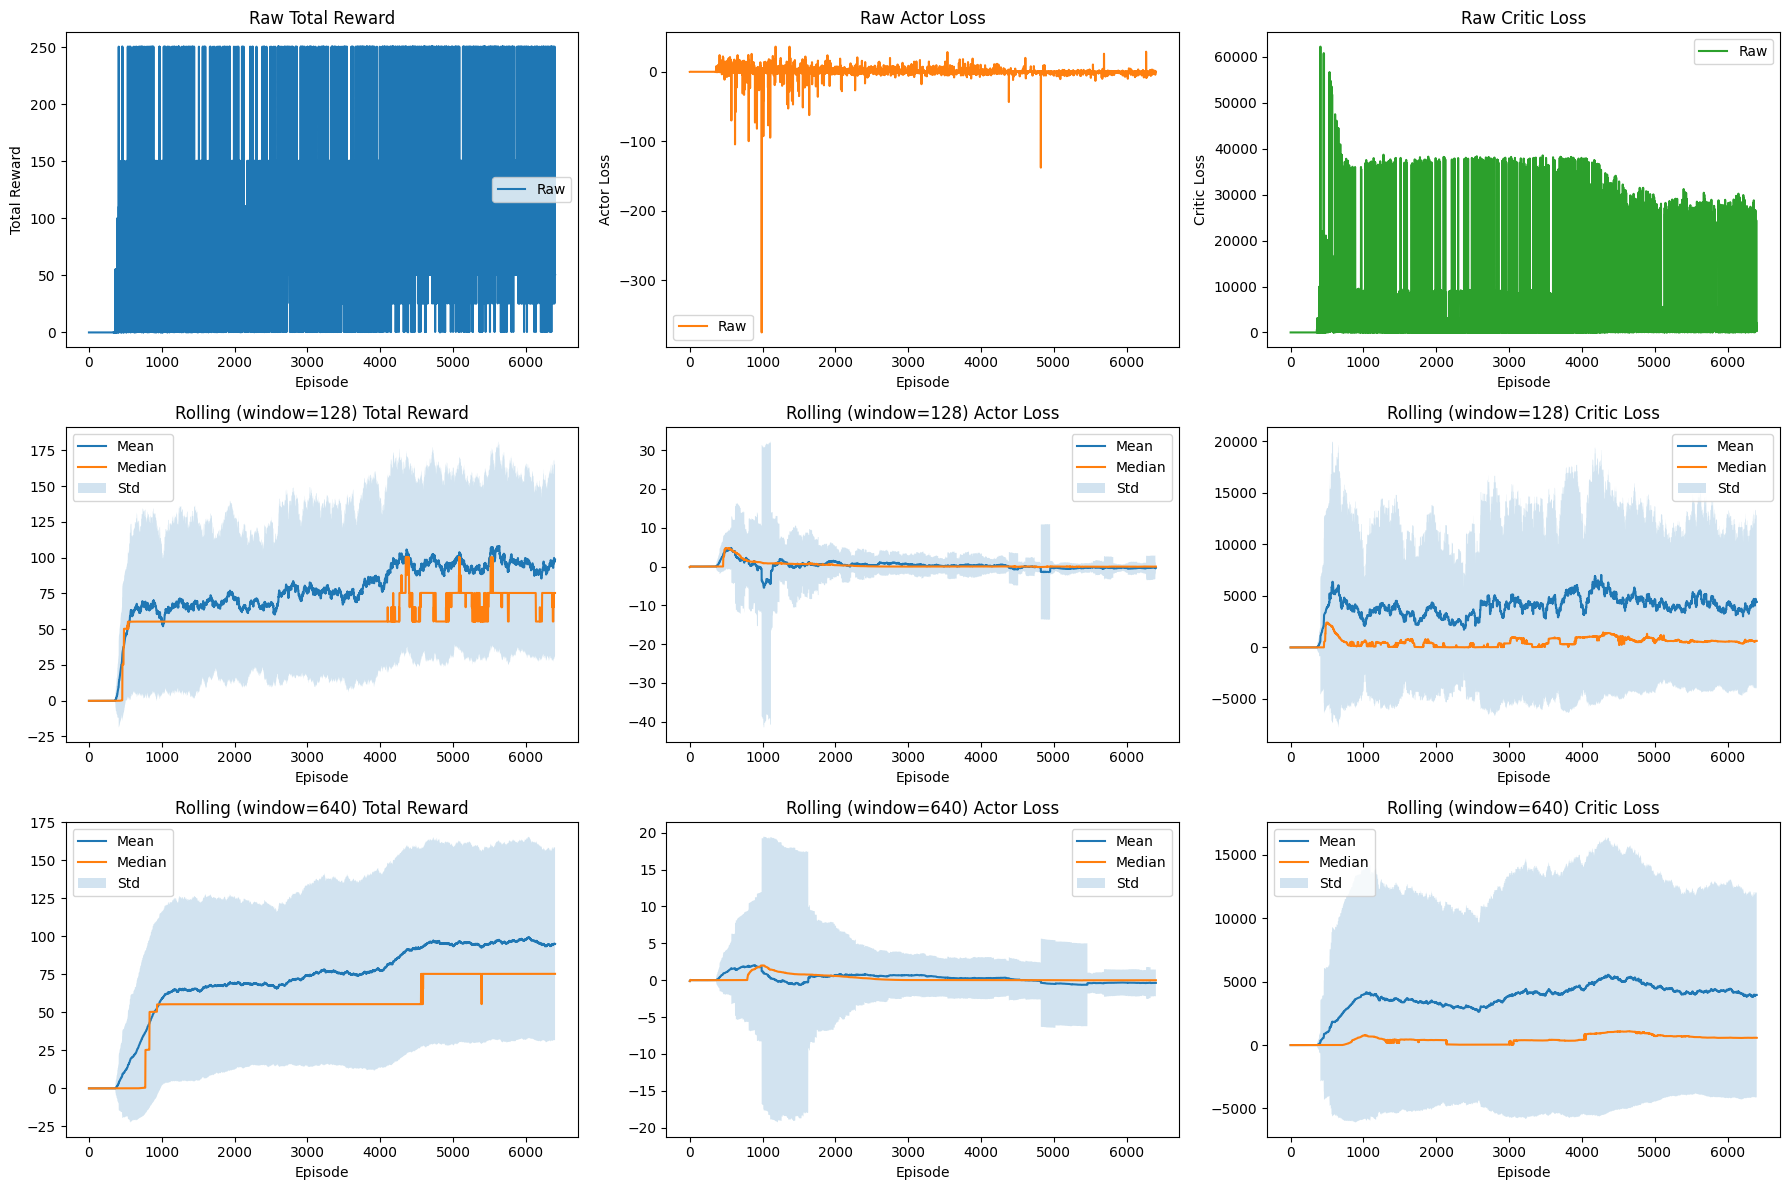

Metrics plot displayed.
Firing rate data not available (models might be Dense or logging was disabled/failed).

  Plotting Psychometric Curve for this stage...


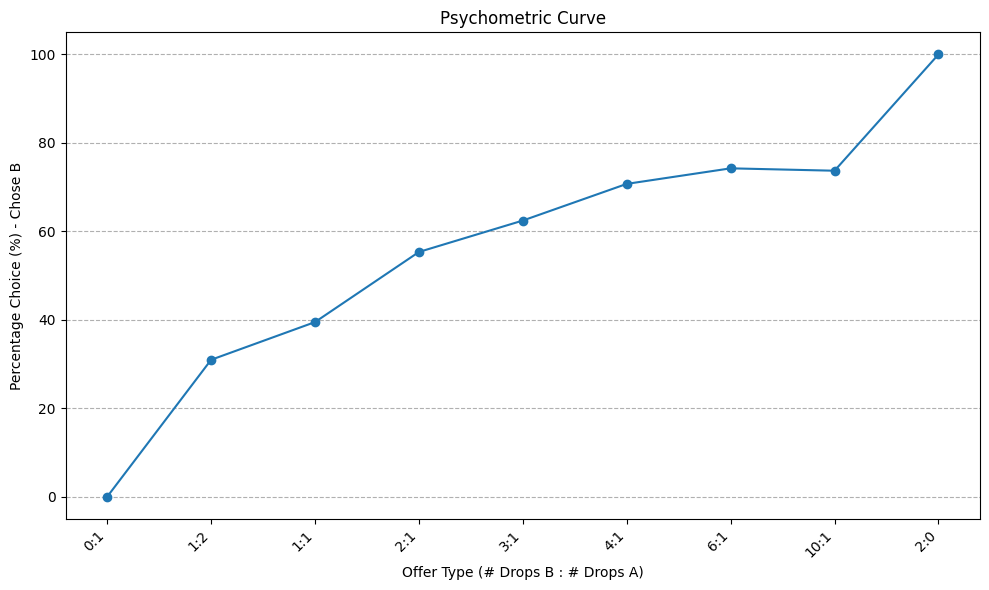

Closing the environment...
Environment closed.


In [1]:
# --- Imports ---
import os
import sys
import gymnasium as gym
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

# --- GPU Configuration ---
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

# --- Add Modules directory to Python path ---
module_path = os.path.abspath(os.path.join('.', 'Modules'))

if module_path not in sys.path:
    sys.path.append(module_path)
    print(f"Added '{module_path}' to sys.path")
else:
    print(f"'{module_path}' already in sys.path")

# --- Import custom modules ---
from env_economic_choice_no_hold import EconomicChoiceEnv
from actor_critic import ActorCriticAgent
from reinforce import train_agent
from helper_functions import plot_metrics, plot_firing_rates, plot_psychometric_curve

# --- Set Random Seeds ---
seed_value = 0
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
random.seed(seed_value)

print("Setup Complete.")

# --- Define Paths for Loading/Saving ---
load_weights_path = None
save_weights_path = "saved_models_80/stage4"

# Ensure save directory exists
save_dir = os.path.dirname(save_weights_path)
if save_dir and not os.path.exists(save_dir):
    os.makedirs(save_dir)
    print(f"Created directory '{save_dir}'")


# --- Training Configuration ---
config = {
    # Environment specific params
    "dt": 10,
    "A_to_B_ratio": 2.2,
    "reward_B": 25,
    "abort_penalty":-0.1,
    "input_noise_sigma": 0.0,
    "reward_fixation": 0.01,
    "reward_go_fixation": -0.01,
    "duration_params": [150, 100, 200, 200],

    # Agent architecture
    "actor_hidden_size": 100,
    "critic_hidden_size": 100,
    "actor_layers": 1,
    "critic_layers": 1,
    "layer_type": "Dense",
    "actor_prob_connection": 0.1,
    "critic_prob_connection": 1.0,

    # Training hyperparameters
    "actor_lr": 5e-4,
    "critic_lr": 5e-4,
    "num_episodes": 6400,
    "gamma": 1.0,
    "l2_actor": 1e-4,
    "l2_critic": 1e-4,

    # Training process  
    "print_interval": 100,
    "record_history": 1
}

print("Configuration loaded:")
for key, value in config.items():
    print(f"  {key}: {value}")

# --- Environment Setup ---
print("Creating Padoa-Schioppa environment...")
env = EconomicChoiceEnv(
    dt=config["dt"],
    A_to_B_ratio=config["A_to_B_ratio"],
    reward_B=config["reward_B"],
    abort_penalty=config["abort_penalty"],
    input_noise_sigma=config["input_noise_sigma"],
    reward_fixation=config["reward_fixation"],
    reward_go_fixation=config["reward_go_fixation"],
    duration_params=config["duration_params"]
)

# Get observation and action space sizes from the actual environment instance
obs_size = env.observation_space.shape[0]
act_size = env.action_space.n
print(f"Observation size: {obs_size}, Action size: {act_size}")

initial_obs, initial_info = env.reset(seed=seed_value)
print(f"Environment reset. Initial info: {initial_info}")

# --- Agent Setup ---
print("Initializing Actor-Critic Agent...")
agent = ActorCriticAgent(
    obs_size=obs_size,
    act_size=act_size,
    actor_hidden_size=config["actor_hidden_size"],
    critic_hidden_size=config["critic_hidden_size"],
    actor_layers=config["actor_layers"],
    critic_layers=config["critic_layers"],
    actor_lr=config["actor_lr"],
    critic_lr=config["critic_lr"],
    actor_prob_connection=config["actor_prob_connection"],
    critic_prob_connection=config["critic_prob_connection"],
    layer_type=config["layer_type"]
)

# Load weights
if load_weights_path:
    print(f"Attempting to load weights from: {load_weights_path}")
    load_successful = agent.load_weights(load_weights_path)
    if not load_successful:
        print(f"WARNING: Failed to load weights. Starting training with initialized weights.")
else:
    print("No weights loaded (load_weights_path is None). Starting from scratch.")

print("Agent Initialized.")

# --- Training ---
print(f"Starting training for {config['num_episodes']} episodes...")

total_rewards_history, actor_loss_history, critic_loss_history, \
actor_firing_rates, critic_firing_rates,  measurements_juices = train_agent(
    env=env,
    agent=agent,
    num_episodes=config["num_episodes"],
    gamma=config["gamma"],
    print_interval=config["print_interval"],
    l2_actor=config["l2_actor"],
    l2_critic=config["l2_critic"],
    record_history=config["record_history"]
)

print("\nTraining finished.")

# Save weights
if save_weights_path:
    print(f"Saving agent weights to: {save_weights_path}")
    agent.save_weights(save_weights_path)
else:
    print("No save path specified (save_weights_path is None). Weights not saved.")

# --- Plot Training Metrics ---
print("Plotting training metrics...")
# Adjust window sizes if needed based on num_episodes
plot_metrics(
    total_rewards_history,
    actor_loss_history,
    critic_loss_history,
    window_1=max(20, config["num_episodes"] // 50),
    window_2=max(50, config["num_episodes"] // 10)
)

print("Metrics plot displayed.")

# --- Plot Firing Rates ---
if actor_firing_rates is not None and critic_firing_rates is not None:
    print("Plotting neuron firing rates...")
    plot_firing_rates(actor_firing_rates, critic_firing_rates)
    print("Firing rate plot displayed.")
# Add checks for partial data as before...
elif actor_firing_rates is not None:
     print("Plotting only Actor firing rates (Critic might be Dense or logging failed)...")
     pass # Add specific plotting if desired
elif critic_firing_rates is not None:
     print("Plotting only Critic firing rates (Actor might be Dense or logging failed)...")
     pass # Add specific plotting if desired
else:
    print("Firing rate data not available (models might be Dense or logging was disabled/failed).")

# --- Plot psychometric curves ---
print("\n  Plotting Psychometric Curve for this stage...")
plot_psychometric_curve(measurements_juices, title=f"Psychometric Curve")

# --- Close the Environment ---
print("Closing the environment...")
env.close()
print("Environment closed.")

### FFNN economic choice full

2025-05-02 01:51:56.866798: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746143518.473137   14209 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746143518.908505   14209 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746143522.787398   14209 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1746143522.787468   14209 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1746143522.787470   14209 computation_placer.cc:177] computation placer alr

Added '/mnt/c/Users/imcir/Desktop/CIENCIA DATOS/Segundo cuatrimestre/TFM/Código/Modules' to sys.path
Setup Complete.
Configuration loaded:
  env_dt_ms: 10
  A_to_B_ratio: 2.2
  reward_B: 1
  abort_penalty: -0.1
  input_noise_sigma: 0.001
  reward_fixation: 0.01
  reward_go_fixation: -0.01
  reward_choice_hold: 0.05
  duration_params: [50, 30, 70, 70, 10]
  actor_hidden_size: 100
  critic_hidden_size: 100
  actor_layers: 1
  critic_layers: 1
  layer_type: Dense
  alpha: 0.1
  actor_prob_connection: 0.1
  critic_prob_connection: 1.0
  actor_lr: 0.005
  critic_lr: 0.005
  num_episodes: 10000
  gamma: 1.0
  l2_actor: 0.0001
  l2_critic: 0.0001
  print_interval: 1000
  record_history: 1
Creating Padoa-Schioppa environment...
Observation size: 4, Action size: 3
Environment reset. Initial info: {'step': 0, 'epoch': 'fixation', 'juice_LR': ('B', 'A'), 'offer_BA': (6, 1), 'nL': 6, 'nR': 1, 'rL': 6.0, 'rR': 2.2, 'chosen_action': -1, 'choice_time_step': -1, 'is_correct_choice': None, 'A_to_B_rati

2025-05-02 01:52:45.612044: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


No weights loaded (load_weights_path is None). Starting from scratch.
Agent Initialized.
Starting training for 10000 episodes...
Episode 1000	Total Reward: 0.17	State [ 0.         -1.          0.          0.19770734]	Actor Loss: 0.0025	Critic Loss: 3.4178
Episode 2000	Total Reward: 2.34	State [ 0.         -1.          0.08303142  0.31107336]	Actor Loss: 0.0023	Critic Loss: 0.0214
Episode 3000	Total Reward: 0.15	State [ 0.         -1.          0.00827746  0.21000457]	Actor Loss: 0.0011	Critic Loss: 3.0208
Episode 4000	Total Reward: 0.15	State [ 0.0000000e+00 -1.0000000e+00  1.7965795e-04  1.9514908e-01]	Actor Loss: 0.0021	Critic Loss: 2.8708
Episode 5000	Total Reward: 0.14	State [ 0.         -1.          0.          0.20041813]	Actor Loss: 0.0020	Critic Loss: 2.6883
Episode 6000	Total Reward: 2.37	State [ 0.        -1.         0.0843184  0.       ]	Actor Loss: 0.0022	Critic Loss: 0.0187
Episode 7000	Total Reward: 3.17	State [0.         1.         0.30112275 0.11807485]	Actor Loss: 0.001

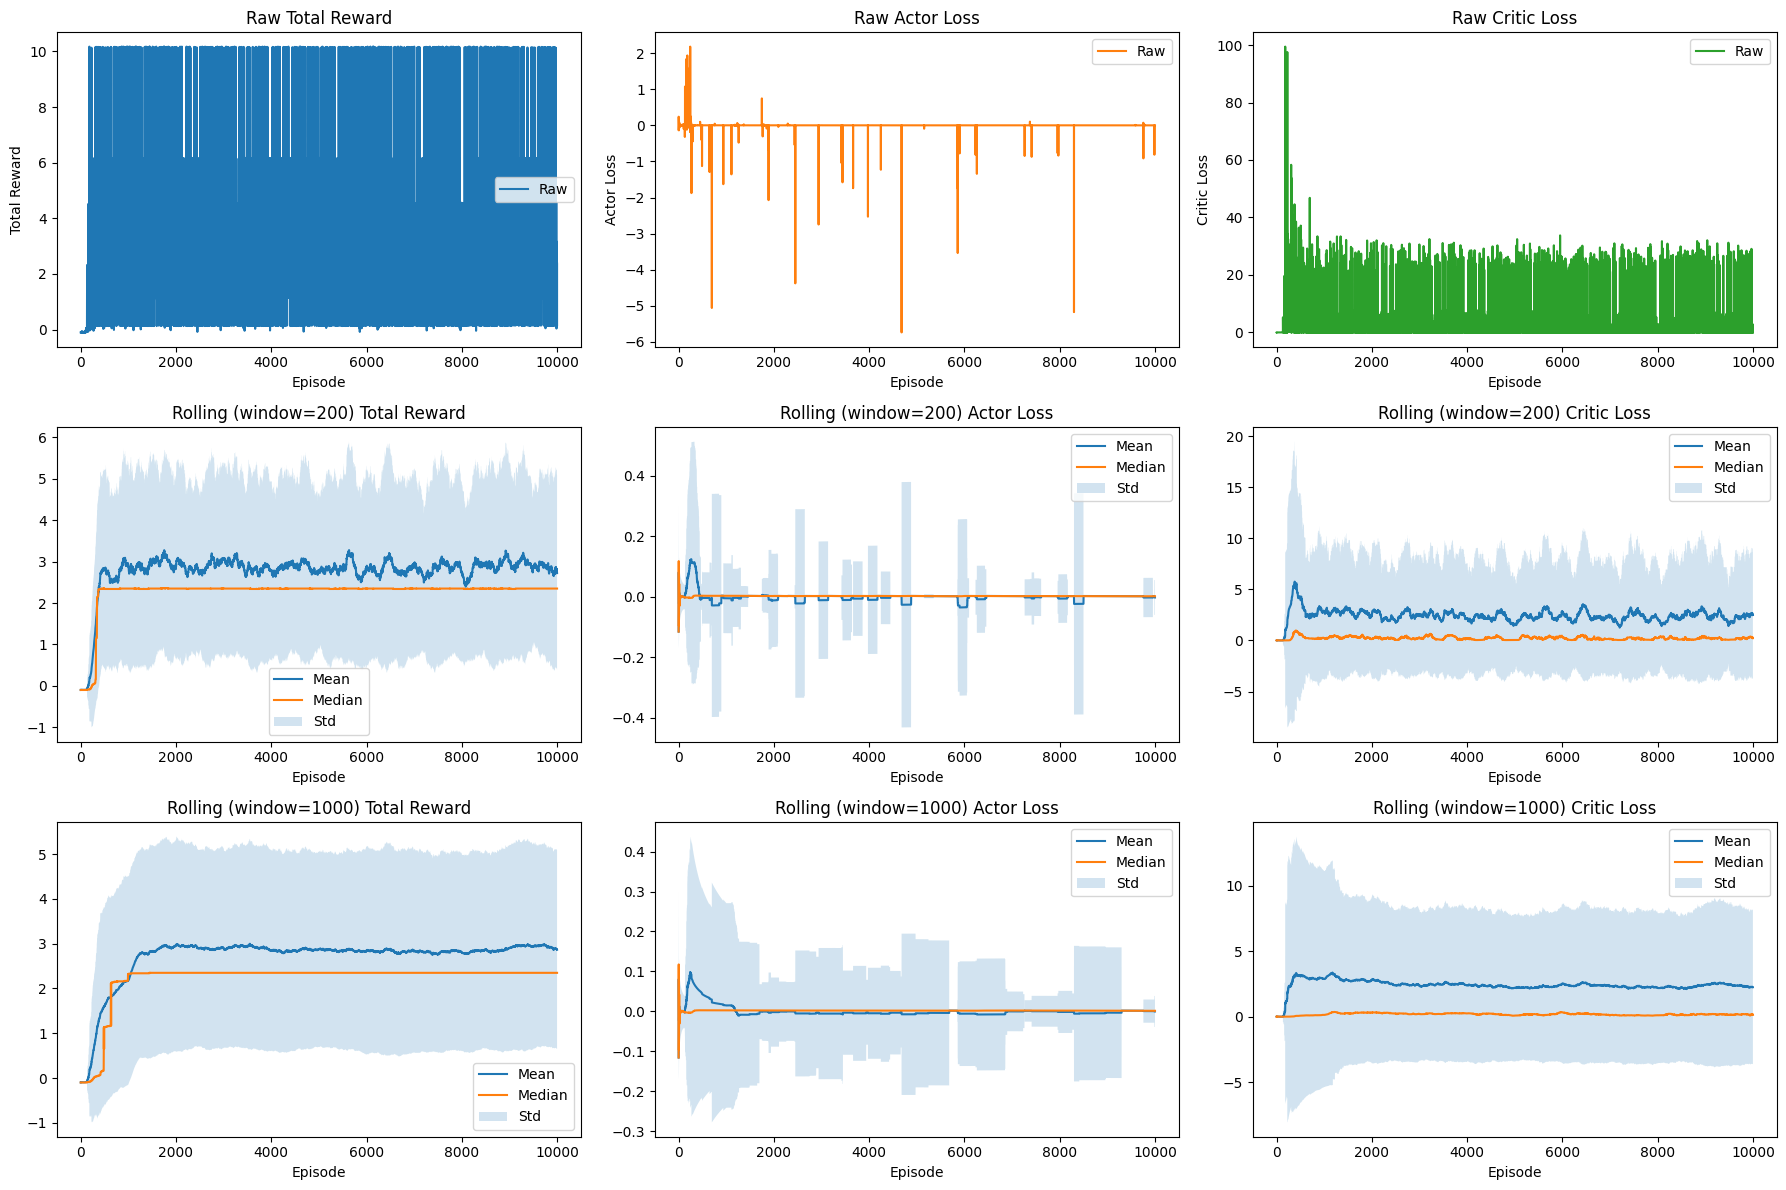

Metrics plot displayed.
Firing rate data not available (models might be Dense or logging was disabled/failed).

  Plotting Psychometric Curve for this stage...


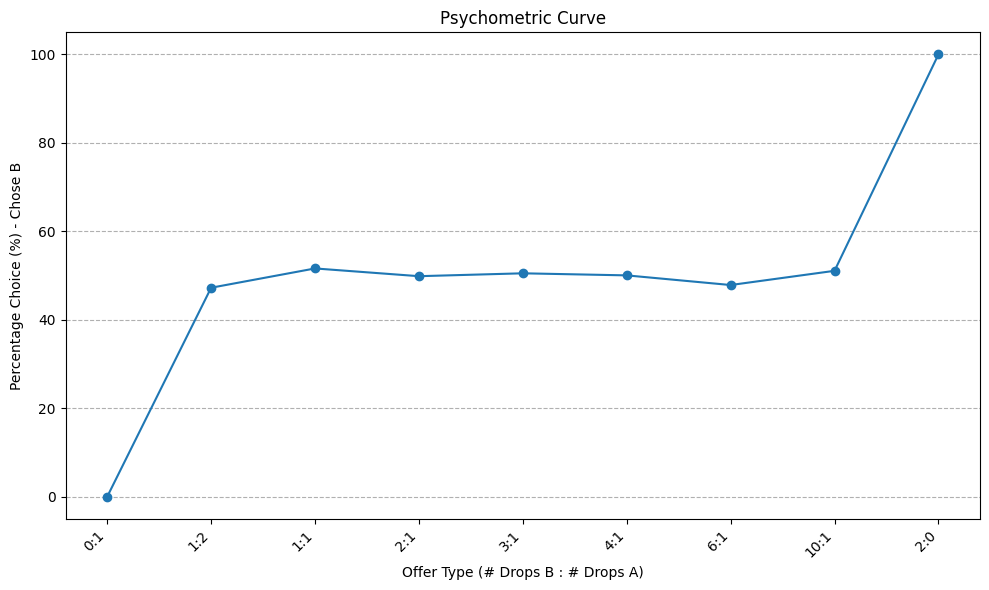

Closing the environment...
Environment closed.


In [1]:
# --- Imports ---
import os
import sys
import gymnasium as gym
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

# --- GPU Configuration ---
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

# --- Add Modules directory to Python path ---
module_path = os.path.abspath(os.path.join('.', 'Modules'))

if module_path not in sys.path:
    sys.path.append(module_path)
    print(f"Added '{module_path}' to sys.path")
else:
    print(f"'{module_path}' already in sys.path")

# --- Import custom modules ---
from env_economic_choice_full import EconomicChoiceEnv
from actor_critic import ActorCriticAgent
from reinforce import train_agent
from helper_functions import plot_metrics, plot_firing_rates, plot_psychometric_curve

# --- Set Random Seeds ---
seed_value = 0
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
random.seed(seed_value)

print("Setup Complete.")

# --- Define Paths for Loading/Saving ---
load_weights_path = None
save_weights_path = "saved_models_80/stage1"

# Ensure save directory exists
save_dir = os.path.dirname(save_weights_path)
if save_dir and not os.path.exists(save_dir):
    os.makedirs(save_dir)
    print(f"Created directory '{save_dir}'")


# --- Training Configuration ---
config = {
    # Environment specific params
    "env_dt_ms": 10,
    "A_to_B_ratio": 2.2,
    "reward_B": 1,
    "abort_penalty": -0.1,
    "input_noise_sigma": 0.001,
    "reward_fixation": 0.01,
    "reward_go_fixation": -0.01,
    "reward_choice_hold": 0.05,
    "duration_params": [50, 30, 70, 70, 10],

    # Agent architecture
    "actor_hidden_size": 100,
    "critic_hidden_size": 100,
    "actor_layers": 1,
    "critic_layers": 1,
    "layer_type": "Dense",
    "alpha": 0.1,
    "actor_prob_connection": 0.1,
    "critic_prob_connection": 1.0,

    # Training hyperparameters
    "actor_lr": 5e-3,
    "critic_lr": 5e-3,
    "num_episodes": 10000,
    "gamma": 1.0,
    "l2_actor": 1e-4,
    "l2_critic": 1e-4,

    # Training process  
    "print_interval": 1000,
    "record_history": 1
}

print("Configuration loaded:")
for key, value in config.items():
    print(f"  {key}: {value}")

# --- Environment Setup ---
print("Creating Padoa-Schioppa environment...")
env = EconomicChoiceEnv(
    dt=config["env_dt_ms"],
    A_to_B_ratio=config["A_to_B_ratio"],
    reward_B=config["reward_B"],
    abort_penalty=config["abort_penalty"],
    input_noise_sigma=config["input_noise_sigma"],
    reward_fixation=config["reward_fixation"],
    reward_go_fixation=config["reward_go_fixation"],
    reward_choice_hold=config["reward_choice_hold"],
    duration_params=config["duration_params"]
)

# Get observation and action space sizes from the actual environment instance
obs_size = env.observation_space.shape[0]
act_size = env.action_space.n
print(f"Observation size: {obs_size}, Action size: {act_size}")

initial_obs, initial_info = env.reset(seed=seed_value)
print(f"Environment reset. Initial info: {initial_info}")

# --- Agent Setup ---
print("Initializing Actor-Critic Agent...")
agent = ActorCriticAgent(
    obs_size=obs_size,
    act_size=act_size,
    actor_hidden_size=config["actor_hidden_size"],
    critic_hidden_size=config["critic_hidden_size"],
    actor_layers=config["actor_layers"],
    critic_layers=config["critic_layers"],
    actor_lr=config["actor_lr"],
    critic_lr=config["critic_lr"],
    actor_prob_connection=config["actor_prob_connection"],
    critic_prob_connection=config["critic_prob_connection"],
    layer_type=config["layer_type"],
    alpha=config["alpha"]
)

# Load weights
if load_weights_path:
    print(f"Attempting to load weights from: {load_weights_path}")
    load_successful = agent.load_weights(load_weights_path)
    if not load_successful:
        print(f"WARNING: Failed to load weights. Starting training with initialized weights.")
else:
    print("No weights loaded (load_weights_path is None). Starting from scratch.")

print("Agent Initialized.")

# --- Training ---
print(f"Starting training for {config['num_episodes']} episodes...")

total_rewards_history, actor_loss_history, critic_loss_history, \
actor_firing_rates, critic_firing_rates,  measurements_juices = train_agent(
    env=env,
    agent=agent,
    num_episodes=config["num_episodes"],
    gamma=config["gamma"],
    print_interval=config["print_interval"],
    l2_actor=config["l2_actor"],
    l2_critic=config["l2_critic"],
    record_history=config["record_history"]
)

print("\nTraining finished.")

# Save weights
if save_weights_path:
    print(f"Saving agent weights to: {save_weights_path}")
    agent.save_weights(save_weights_path)
else:
    print("No save path specified (save_weights_path is None). Weights not saved.")

# --- Plot Training Metrics ---
print("Plotting training metrics...")
# Adjust window sizes if needed based on num_episodes
plot_metrics(
    total_rewards_history,
    actor_loss_history,
    critic_loss_history,
    window_1=max(20, config["num_episodes"] // 50),
    window_2=max(50, config["num_episodes"] // 10)
)

print("Metrics plot displayed.")

# --- Plot Firing Rates ---
if actor_firing_rates is not None and critic_firing_rates is not None:
    print("Plotting neuron firing rates...")
    plot_firing_rates(actor_firing_rates, critic_firing_rates)
    print("Firing rate plot displayed.")
# Add checks for partial data as before...
elif actor_firing_rates is not None:
     print("Plotting only Actor firing rates (Critic might be Dense or logging failed)...")
     pass # Add specific plotting if desired
elif critic_firing_rates is not None:
     print("Plotting only Critic firing rates (Actor might be Dense or logging failed)...")
     pass # Add specific plotting if desired
else:
    print("Firing rate data not available (models might be Dense or logging was disabled/failed).")

# --- Plot psychometric curves ---
print("\n  Plotting Psychometric Curve for this stage...")
plot_psychometric_curve(measurements_juices, title=f"Psychometric Curve")

# --- Close the Environment ---
print("Closing the environment...")
env.close()
print("Environment closed.")